### Imports

In [1]:
import random
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.modeling import models, fitting
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from astropy.stats import akaike_info_criterion_lsq
from tabulate import tabulate
from scipy.signal import find_peaks, windows, savgol_filter
from scipy.integrate import simpson

## Signal analysis

### Single signal handling

In [12]:
# Manually find number of points in a signal
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

signal = time['vHI'].values

num_points = len(signal)
print(f"Signal has {num_points} points.")


Signal has 948 points.


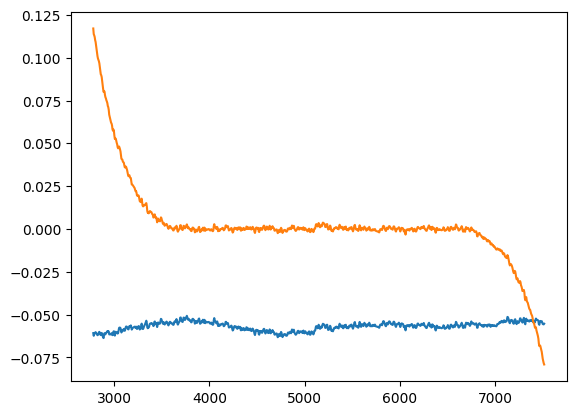

In [5]:
file = 'mangaHI-7972-3701.csv'

timeSeries = pd.read_csv(file, names = ('vHI','fHI', 'fBHI'))

time = timeSeries[22:-1].copy()
time[['vHI','fHI','fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

plt.plot(time['vHI'], time['fBHI'])
plt.plot(time['vHI'], time['fHI'])

plt.show()

#### Dictionary creation for easier task execution

In [2]:
signalsDict = {
    1: "mangaHI-7443-1901.csv",
    2: "mangaHI-7443-1902.csv",
    3: "mangaHI-7972-3701.csv",
    4: "mangaHI-8077-12705.csv",
    5: "mangaHI-8081-12702.csv",
    6: "mangaHI-8084-3704.csv",
    7: "NGC 1068.txt",
    8: "NGC 3521.txt",
    9: "NGC 4565.txt",
    10: "NGC 4725.txt",
    11: "NGC 6822.txt"
}

In [15]:
# Dictionary to store results
metrics = {}

for key, file in signalsDict.items():
    file_extension = os.path.splitext(file)[-1].lower()

    try:
        if file_extension == ".csv":
            timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
            time = timeSeries[22:-1].copy()
            time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
            time = time.reset_index(drop=True).astype(float)
            
            x = time["vHI"].values
            y = time["fHI"].values

        elif file_extension == ".txt":
            timeSeries = pd.read_csv(file, sep=r'\s+', comment="#", names=["vHI", "fHI"])
            x = timeSeries["vHI"].values
            y = timeSeries["fHI"].values
        
        else:
            print(f"Skipping {file}: Error")
            continue

        # Mean and std dev calculation
        mean_value = np.mean(y)
        std_dev = np.std(y)

        # Store results
        metrics[file] = {"Mean": mean_value, "Std Dev": std_dev}

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Print results
for file, values in metrics.items():
    print(f"{file}: Mean = {values['Mean']:.5f}, Std Dev = {values['Std Dev']:.5f}")

mangaHI-7443-1901.csv: Mean = -0.00005, Std Dev = 0.00159
mangaHI-7443-1902.csv: Mean = 0.00103, Std Dev = 0.00258
mangaHI-7972-3701.csv: Mean = 0.00248, Std Dev = 0.02466
mangaHI-8077-12705.csv: Mean = 0.00004, Std Dev = 0.00132
mangaHI-8081-12702.csv: Mean = 0.37508, Std Dev = 0.87530
mangaHI-8084-3704.csv: Mean = 0.00021, Std Dev = 0.00143
NGC 1068.txt: Mean = 0.00968, Std Dev = 0.02833
NGC 3521.txt: Mean = 0.22182, Std Dev = 0.27392
NGC 4565.txt: Mean = 0.07983, Std Dev = 0.19134
NGC 4725.txt: Mean = 0.03011, Std Dev = 0.10266
NGC 6822.txt: Mean = 2.63865, Std Dev = 7.87491


### Gaussian fitting and error estimation

C:\Users\petri\AppData\Local\Temp\ipykernel_29464\3728635574.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  timeSeries = pd.read_csv(file, delim_whitespace=True, comment="#", names=["vHI", "fHI"])


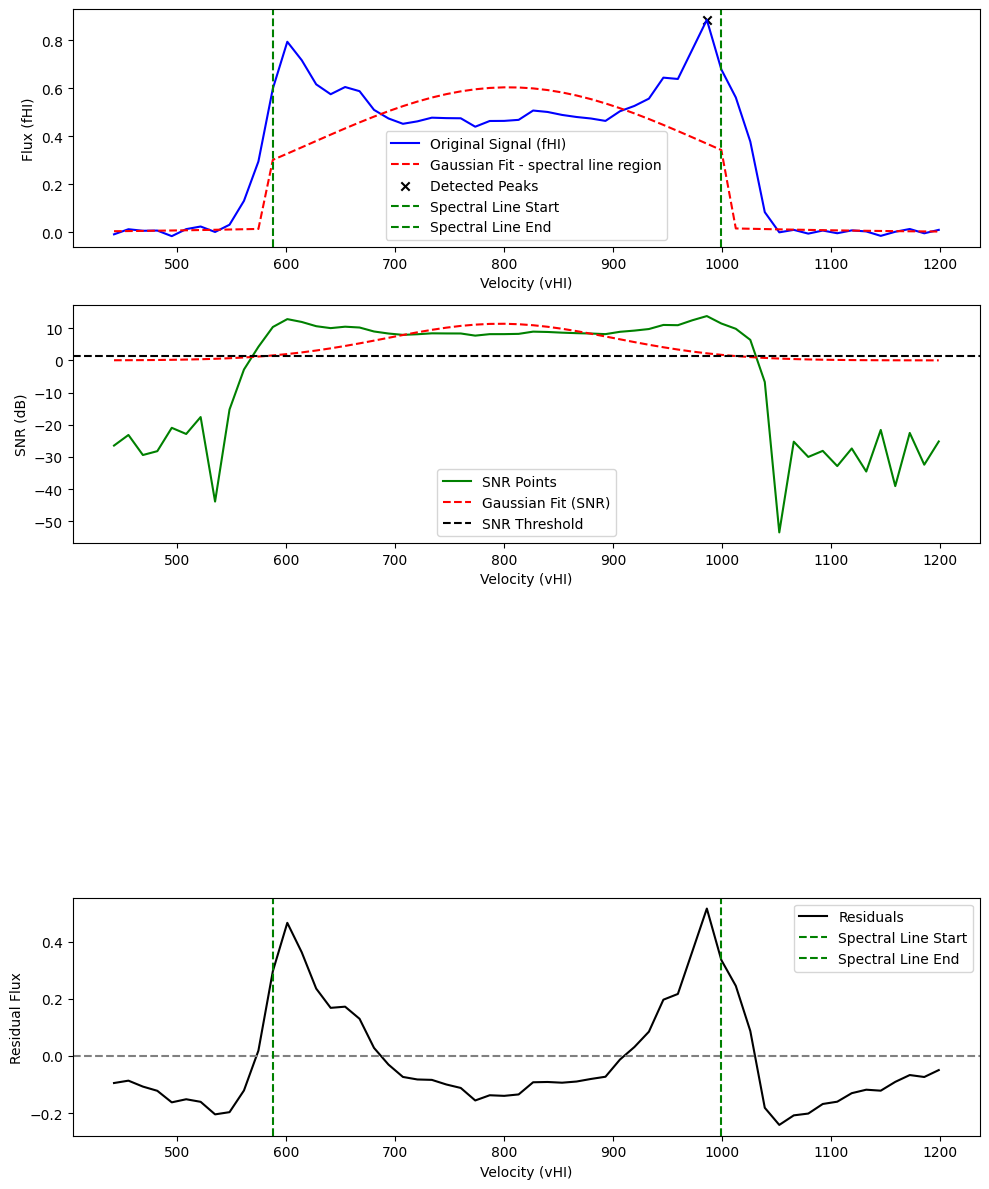

In [17]:
# Input file
file = "NGC 3521.txt"

# Determine file type
file_extension = os.path.splitext(file)[-1].lower()

# Load data
if file_extension == ".csv":
    timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
    time = timeSeries[22:-1].copy()
    time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
    time = time.reset_index(drop=True).astype(float)
    
    x = time["vHI"].values
    y = time["fHI"].values  # Used for Gaussian fitting
    y_original = time["fBHI"].values  # Original signal for plotting

elif file_extension == ".txt":
    timeSeries = pd.read_csv(file, delim_whitespace=True, comment="#", names=["vHI", "fHI"])
    x = timeSeries["vHI"].values
    y = timeSeries["fHI"].values
    y_original = None  # No fBHI in txt file data

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
if y_original is not None:
    y_original_trimmed = y_original[start_index:end_index+1]

# Find peaks in the signal
peak_indices, properties = find_peaks(y_trimmed, height=np.mean(y_trimmed) + 2 * np.std(y_trimmed),
                                      prominence=np.std(y_trimmed) / 2, width=2)

# Fit a Gaussian model to each detected peak
if len(peak_indices) > 0:
    fitter = fitting.LevMarLSQFitter()
    g_init = None

    for peak_idx in peak_indices:
        peak_x = x_trimmed[peak_idx]
        peak_y = y_trimmed[peak_idx]
        stddev_guess = 5  # Initial guess

        # Create a Gaussian model for this peak
        g_model = models.Gaussian1D(amplitude=peak_y, mean=peak_x, stddev=stddev_guess)

        if g_init is None:
            g_init = g_model
        else:
            g_init += g_model  # Sum multiple Gaussians

    # Fit the combined Gaussian model
    g_fit = fitter(g_init, x_trimmed, y_trimmed)
    signal_fit = g_fit(x_trimmed)

else:
    print("No significant peaks found.")
    signal_fit = np.zeros_like(y_trimmed)

# Compute residuals (fHI - Gaussian fit)
residuals = y_trimmed - signal_fit

# Implement SNR logic
snr_threshold = 1.5  # Adjusted for Gaussian fit
snr_points = 20 * np.log10(np.abs(y_trimmed / np.std(residuals)))
SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
SNR_g_fit = fitter(SNR_g_init, x_trimmed, snr_points)

# Identify spectral line region based on SNR
line_indices = np.where(SNR_g_fit(x_trimmed) > snr_threshold)[0]

# Suppress Fit Outside Spectral Line Region
mask = np.zeros_like(y_trimmed)
if len(line_indices) > 0:
    mask[line_indices] = 1
    signal_fit = signal_fit * mask + signal_fit * (1 - mask) * 0.05  # Reduce non-spectral regions

# Plot results
plt.figure(figsize=(10, 12))

# Plot 1: fHI signal and Gaussian fit
plt.subplot(4, 1, 1)
plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
plt.plot(x_trimmed, signal_fit, 'r--', label='Gaussian Fit - spectral line region')
plt.scatter(x_trimmed[peak_indices], y_trimmed[peak_indices], color='black', marker='x', label="Detected Peaks")
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Flux (fHI)")
plt.legend()

# Plot 2: SNR points and Gaussian fit
plt.subplot(4, 1, 2)
plt.plot(x_trimmed, snr_points, 'g-', label='SNR Points')
plt.plot(x_trimmed, SNR_g_fit(x_trimmed), 'r--', label="Gaussian Fit (SNR)")
plt.axhline(y=snr_threshold, color='k', linestyle='--', label='SNR Threshold')
plt.xlabel("Velocity (vHI)")
plt.ylabel("SNR (dB)")
plt.legend()

# Plot 3: Original fBHI signal (Only for CSV input)
if y_original is not None:
    plt.subplot(4, 1, 3)
    plt.plot(x, y_original, 'm-', label='Original Signal (fBHI)')
    plt.xlabel("Velocity (vHI)")
    plt.ylabel("Flux (fBHI)")
    plt.legend()

# Plot 4: Residuals (fHI - Gaussian fit)
plt.subplot(4, 1, 4)
plt.plot(x_trimmed, residuals, '-k', label='Residuals')
plt.axhline(0, color='gray', linestyle='--')
if len(line_indices) > 0:
    plt.axvline(x_trimmed[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
    plt.axvline(x_trimmed[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")
plt.xlabel("Velocity (vHI)")
plt.ylabel("Residual Flux")
plt.legend()

plt.tight_layout()
plt.show()

### Spectral line definition using derivatives

#### Smoothing functions

In [7]:
# --- Smoothing Functions ---
def rolling_mean_smooth(signal, window_size):
    return pd.Series(signal).rolling(window=window_size, center=True, min_periods=1).mean().values

def savgol_smooth(signal, window_size, poly_order):
    if window_size % 2 == 0:
        window_size += 1  # Ensure odd window size
    return savgol_filter(signal, window_size, poly_order)

def hann_smooth(signal, window_size):
    if window_size % 2 == 0:
        window_size += 1  # Ensure odd window size
    hann_window = windows.hann(window_size)
    return np.convolve(signal, hann_window / hann_window.sum(), mode="same")

#### Pipeline functions

In [22]:
# Recursive Spectral Identification
def filter_spectral_regions(ranges):
    """Recursively filter spectral regions, starting with the largest integral region
    and stopping when no region exceeds 15x the mean integral of the remaining ones."""
    spectral_regions = []
    iteration = 1

    if not ranges:
        return []

    largest_region = max(ranges, key=lambda x: x[2])
    ranges.remove(largest_region)
    spectral_regions.append(largest_region)

    while ranges:
        mean_integral = np.mean([r[2] for r in ranges]) if ranges else 0
        new_spectral = [r for r in ranges if r[2] > 15 * mean_integral]

        if not new_spectral:
            break

        for region in new_spectral:
            spectral_regions.append(region)

        ranges = [r for r in ranges if r not in new_spectral]
        iteration += 1

    return spectral_regions


# Merge Adjacent Spectral Regions 
def merge_adjacent_spectral_regions(positive_regions, negative_regions):
    """Merges a negative spectral region with a following positive spectral region if they are consecutive.
    Also keeps track of the merged regions (in the form of their indices)"""

    global labeled_spectral_lines
    merged_spectral_lines = []
    merged_indices = set()

    for neg_idx, (neg_start, neg_end, _) in enumerate(negative_regions):
        for pos_idx, (pos_start, pos_end, _) in enumerate(positive_regions):
            if np.isclose(neg_end, pos_start, atol=1e-3):
                merged_spectral_lines.append((neg_start, pos_end))
                merged_indices.update({neg_idx, pos_idx})
                labeled_spectral_lines.append((neg_start, pos_end, "Adjacent Merge"))

    return merged_spectral_lines, merged_indices  # Return merged regions + indices of merged ones


# Merge Matching Spectral Regions
def merge_matching_spectral_regions(positive_regions, negative_regions, merged_indices):
    """Sort positive and negative integral regions from largest to smallest and pair them accordingly.
    If the gap between a pair is higher than the mean of the rest of the signal, label as "Two-Horned Matched".
    Otherwise, label as "Matched Merge"."""
    
    global labeled_spectral_lines

    # Filter out already-merged regions
    positive_filtered = [region for i, region in enumerate(positive_regions) if i not in merged_indices]
    negative_filtered = [region for i, region in enumerate(negative_regions) if i not in merged_indices]

    # Sort by integral value (descending)
    positive_sorted = sorted(positive_filtered, key=lambda x: x[2], reverse=True)
    negative_sorted = sorted(negative_filtered, key=lambda x: x[2], reverse=True)

    merged_regions = []
    num_pairs = min(len(positive_sorted), len(negative_sorted))

    for i in range(num_pairs):
        pos_start, pos_end, _ = positive_sorted[i]
        neg_start, neg_end, _ = negative_sorted[i]

        region_start = min(pos_start, neg_start)
        region_end = max(pos_end, neg_end)

        # Check the two-horned condition
        if region_end > region_start:
            gap_y_values = y_trimmed[min(pos_end, neg_end):max(pos_start, neg_start)]

            if len(gap_y_values) > 0:
                min_gap_value = np.min(gap_y_values)

                # Mask to exclude spectral regions
                mask = np.ones_like(y_trimmed, dtype=bool)
                for s, e, _ in labeled_spectral_lines:
                    mask[s:e] = False
                mean_rest_signal = np.mean(y_trimmed[mask])

                if min_gap_value > mean_rest_signal:
                    label = "Two-Horned Matched"
                else:
                    label = "Matched Merge"
            else:
                label = "Matched Merge"
        else:
            label = "Matched Merge"

        merged_regions.append((region_start, region_end))
        labeled_spectral_lines.append((region_start, region_end, label))

        print(f"Pair {i+1}: Positive ({pos_start}-{pos_end}) and Negative ({neg_start}-{neg_end}) "
              f"--> Merged ({region_start}-{region_end}) | Label: {label}")

    return merged_regions



def merge_spectral_lines_into_two_horned(spectral_lines, y_trimmed):
    """Merges two spectral lines into a \"two-horned\" signal if the minimum value in the region
    between them is greater than the mean value of the rest of the signal."""

    global labeled_spectral_lines
    if len(spectral_lines) < 2:
        return spectral_lines

    merged_spectral_lines = spectral_lines.copy()
    i = 0

    while i < len(merged_spectral_lines) - 1:
        start1, end1 = merged_spectral_lines[i]
        start2, end2 = merged_spectral_lines[i + 1]

        if end1 >= start2:
            i += 1
            continue

        gap_y_values = y_trimmed[end1:start2]
        if len(gap_y_values) == 0:
            i += 1
            continue

        min_gap_value = np.min(gap_y_values)

        mask = np.ones_like(y_trimmed, dtype=bool)
        for s, e in merged_spectral_lines:
            mask[s:e] = False
        mean_rest_signal = np.mean(y_trimmed[mask])

        if min_gap_value > mean_rest_signal:
            merged_spectral_lines[i] = (start1, end2)
            del merged_spectral_lines[i + 1]
            labeled_spectral_lines.append((start1, end2, "Two-Horned Merge"))
        else:
            i += 1

    return merged_spectral_lines


# Ignore nested spectral lines (if any exist)
def ignore_nested_spectral_lines(spectral_lines):
    """Checks if one spectral line is fully inside another one and ignores it."""
    
    global labeled_spectral_lines
    if len(spectral_lines) < 2:
        return spectral_lines

    new_spectral_lines = spectral_lines.copy()
    i = 0

    while i < len(new_spectral_lines) - 1:
        start1, end1 = new_spectral_lines[i]
        start2, end2 = new_spectral_lines[i + 1]

        if (start2 > start1 and end2 < end1):
            del new_spectral_lines[i + 1]
            # Remove corresponding label as well
            labeled_spectral_lines = [
                (s, e, label) for s, e, label in labeled_spectral_lines
                if not (s == start2 and e == end2)
            ]
        else:
            i += 1

    return new_spectral_lines

#### Pipeline implementation

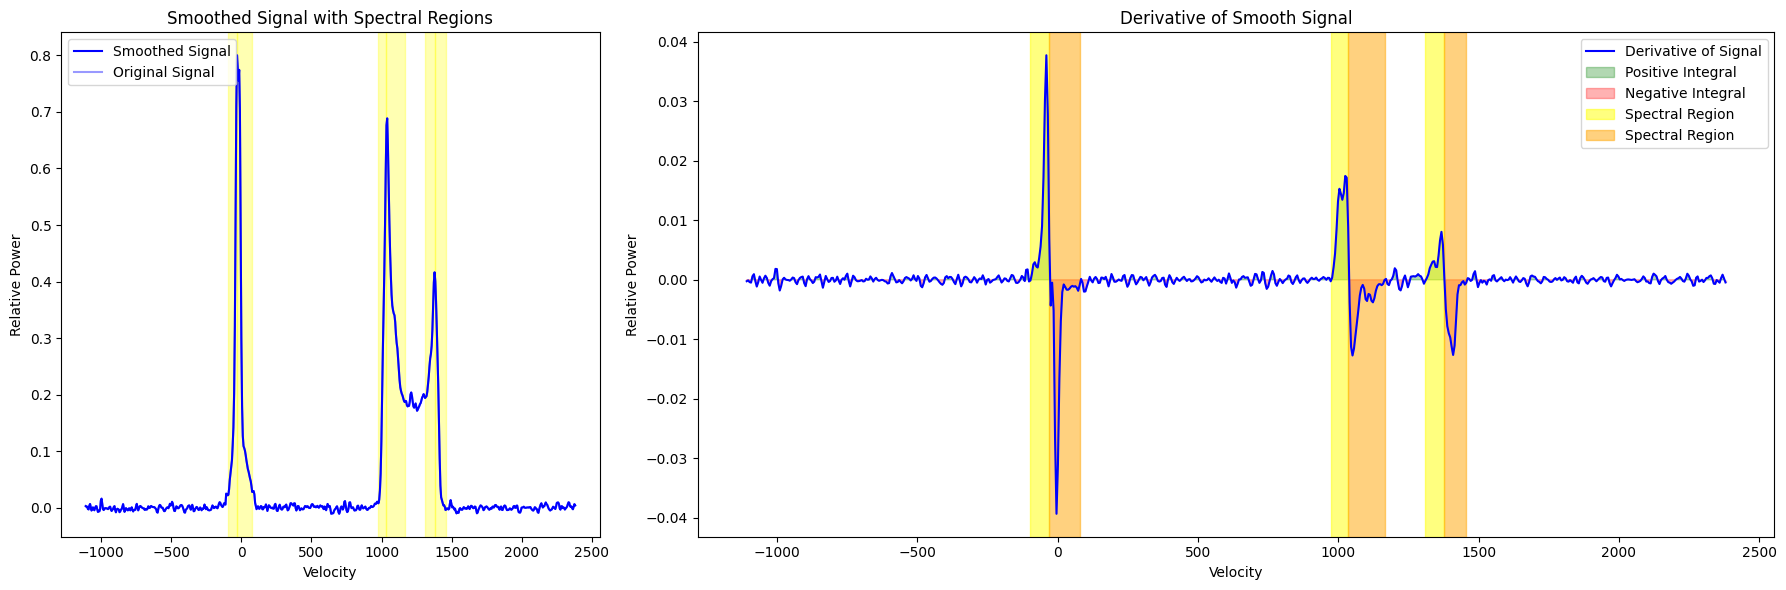

Spectral Lines Identified (Before Two-Horn Merge):
  Spectral Line 1: Start = 1456.100, End = 1310.500
  Spectral Line 2: Start = 1165.000, End = 973.000
  Spectral Line 3: Start = 78.400, End = -96.700


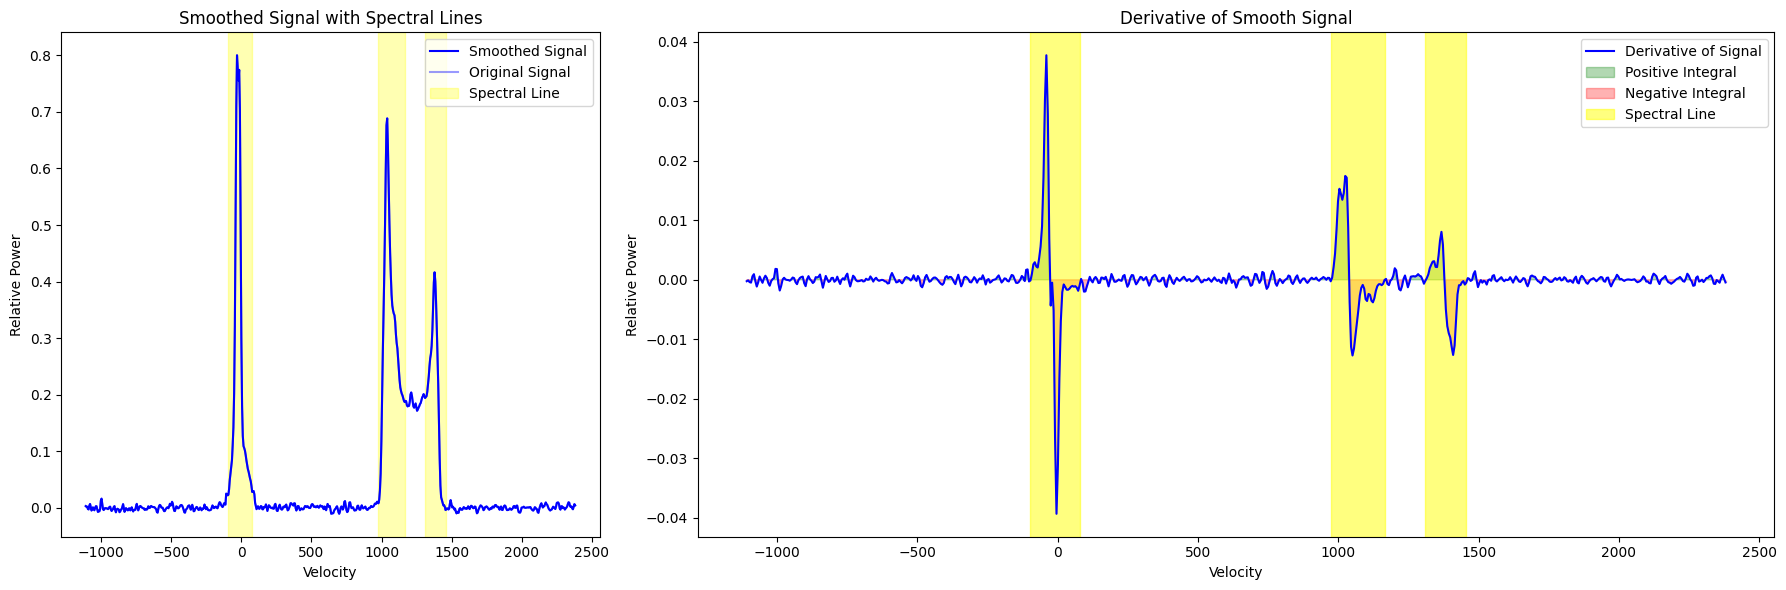

Removing nested spectral lines

Final Spectral Lines:
  Spectral Line 1: Start = 1456.100, End = 973.000
  Spectral Line 2: Start = 78.400, End = -96.700


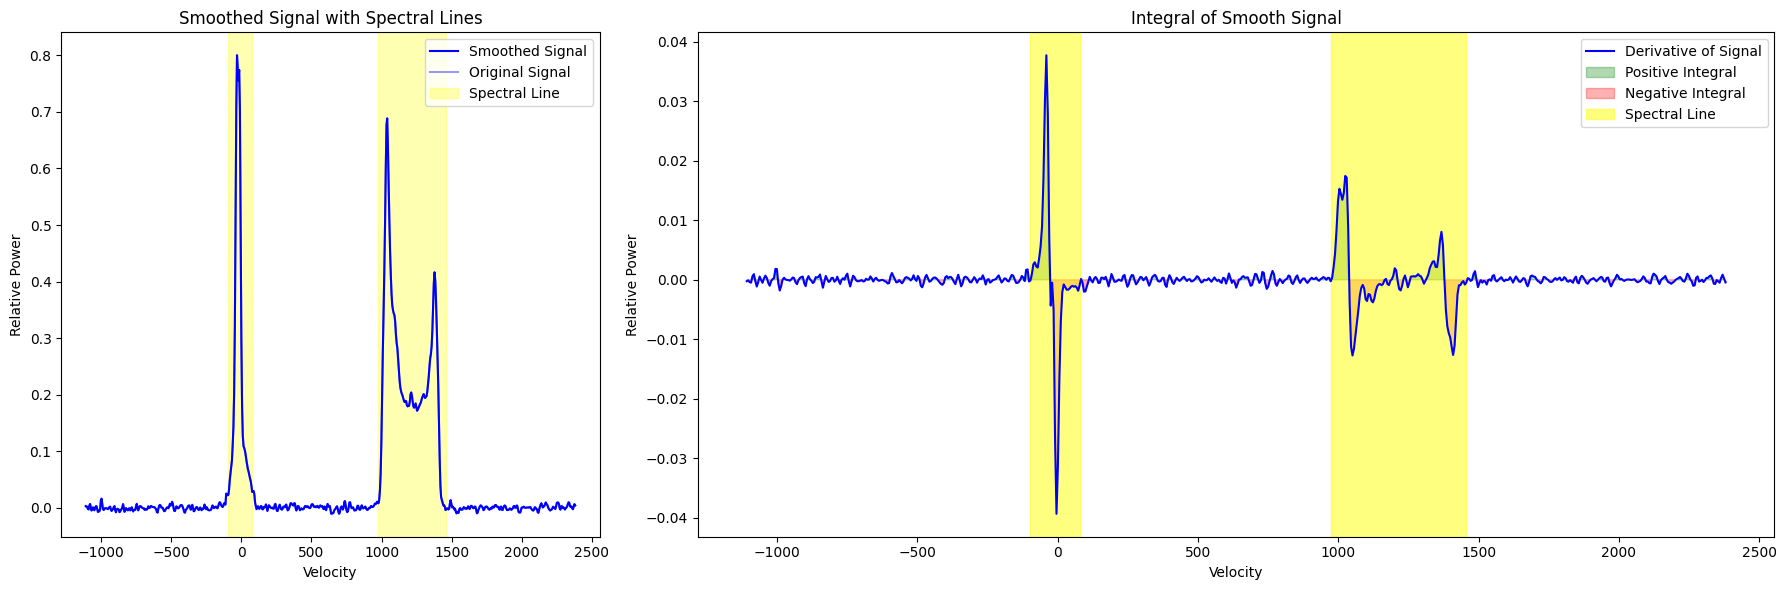

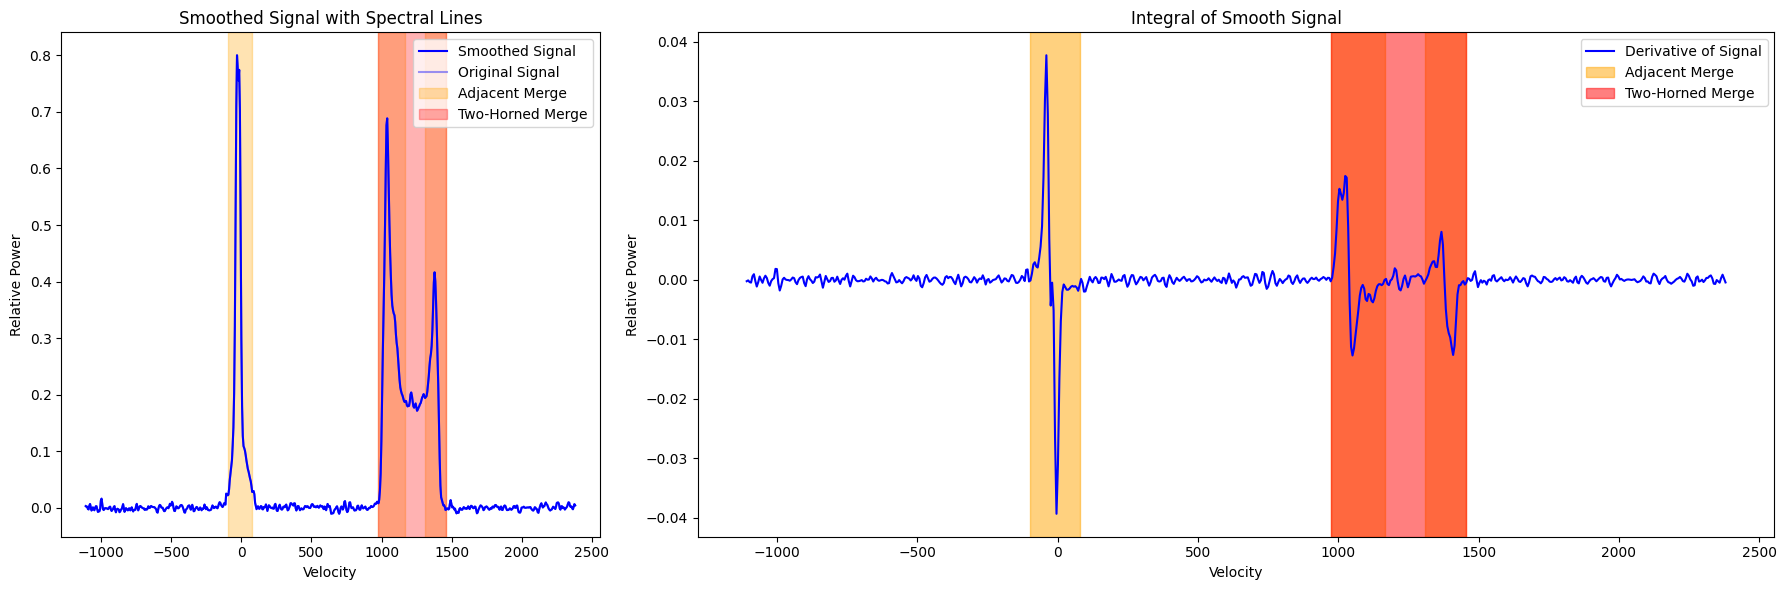

Final Spectral Line Summary
 1. Adjacent Merge       — Start: 78.400, End: -96.700
 2. Adjacent Merge       — Start: 1456.100, End: 1310.500
 3. Adjacent Merge       — Start: 1165.000, End: 973.000
 4. Two-Horned Merge     — Start: 1456.100, End: 973.000


In [ ]:
# Load Data
file = "NGC 4725.txt"

file_extension = os.path.splitext(file)[-1].lower()

if file_extension == ".csv":
    timeSeries = pd.read_csv(file, names=["vHI", "fHI", "fBHI"])
    time = timeSeries[22:-1].copy()
    time[["vHI", "fHI", "fBHI"]] = time["vHI"].str.split(expand=True)
    time = time.reset_index(drop=True).astype(float)
    
    x = time["vHI"].values
    y = time["fHI"].values
    y_original = time["fBHI"].values

elif file_extension == ".txt":
    timeSeries = pd.read_csv(file, sep=r'\s+', comment="#", names=["vHI", "fHI"])
    x = timeSeries["vHI"].values
    y = timeSeries["fHI"].values
    y_original = None

# Clip Data
clip_fraction = 0.17
n_points = len(x)
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]

# Apply Smoothing
y_rolling = rolling_mean_smooth(y_trimmed, window_size=5)
y_savgol = savgol_smooth(y_rolling, window_size=7, poly_order=3)
y_smoothed = hann_smooth(y_savgol, window_size=7)

if file_extension == ".txt":
    y_smoothed = y_trimmed

# Compute Derivative
derivative = np.gradient(y_smoothed, x_trimmed)

# Identify Positive and Negative Regions
positive_ranges = []
negative_ranges = []
current_start = None
current_sign = None

for i in range(1, len(derivative)):
    if derivative[i] > 0:
        if current_sign != 'positive':
            if current_sign == 'negative' and current_start is not None:
                integral = np.trapezoid(derivative[current_start:i], x_trimmed[current_start:i])
                negative_ranges.append((current_start, i, np.abs(integral)))
            current_start = i
            current_sign = 'positive'
    elif derivative[i] < 0:
        if current_sign != 'negative':
            if current_sign == 'positive' and current_start is not None:
                integral = np.trapezoid(derivative[current_start:i], x_trimmed[current_start:i])
                positive_ranges.append((current_start, i, np.abs(integral)))
            current_start = i
            current_sign = 'negative'

# Final integrals for last detected regions
if current_sign == 'positive' and current_start is not None:
    integral = np.trapezoid(derivative[current_start:], x_trimmed[current_start:])
    positive_ranges.append((current_start, len(derivative), integral))
elif current_sign == 'negative' and current_start is not None:
    integral = np.trapezoid(derivative[current_start:], x_trimmed[current_start:])
    negative_ranges.append((current_start, len(derivative), integral))

#----------------------------------------------------------------------------------------------------------

# Initialize list for labelling of spectral lines
labeled_spectral_lines = []

# Recursively Filter Spectral Regions
positive_spectral_regions = filter_spectral_regions(positive_ranges)
negative_spectral_regions = filter_spectral_regions(negative_ranges)

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(x_trimmed, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(x_trimmed, y_trimmed, label='Original Signal', alpha=0.4, color='blue')

# Highlight detected spectral regions
for region in positive_spectral_regions + negative_spectral_regions:
    axs[0].axvspan(x_trimmed[region[0]], x_trimmed[region[1]], color='yellow', alpha=0.3)

axs[0].set_title('Smoothed Signal with Spectral Regions')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(x_trimmed, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(x_trimmed, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(x_trimmed, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral regions in derivative plot
for region in positive_spectral_regions:
    axs[1].axvspan(x_trimmed[region[0]], x_trimmed[region[1]], color='yellow', alpha=0.5, label='Spectral Region' if region == positive_spectral_regions[0] else "")
for region in negative_spectral_regions:
    axs[1].axvspan(x_trimmed[region[0]], x_trimmed[region[1]], color='orange', alpha=0.5, label='Spectral Region' if region == negative_spectral_regions[0] else "")

axs[1].set_title('Derivative of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------------------------------------------

# Merge adjacent and matching spectral lines into one list
merged_spectral_lines_adjacent, merged_indices = merge_adjacent_spectral_regions(positive_spectral_regions, negative_spectral_regions)
merged_spectral_lines_matching = merge_matching_spectral_regions(positive_spectral_regions, negative_spectral_regions, merged_indices)

# Combine both lists and remove duplicates
merged_spectral_lines = list(set(merged_spectral_lines_adjacent + merged_spectral_lines_matching))
merged_spectral_lines.sort()

# Print Results
print("Spectral Lines Identified (Before Two-Horn Merge):")
for idx, (start, end) in enumerate(merged_spectral_lines, 1):
    print(f"  Spectral Line {idx}: Start = {x_trimmed[start]:.3f}, End = {x_trimmed[end]:.3f}")

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(x_trimmed, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(x_trimmed, y_trimmed, label='Original Signal', alpha=0.4, color='blue')

# Highlight merged spectral lines
for start, end in merged_spectral_lines:
    axs[0].axvspan(x_trimmed[start], x_trimmed[end], color='yellow', alpha=0.3, label="Spectral Line" if start == merged_spectral_lines[0][0] else "")

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(x_trimmed, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(x_trimmed, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(x_trimmed, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral lines in derivative plot
for start, end in merged_spectral_lines:
    axs[1].axvspan(x_trimmed[start], x_trimmed[end], color='yellow', alpha=0.5, label="Spectral Line" if start == merged_spectral_lines[0][0] else "")

axs[1].set_title('Derivative of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------------------------------------------

print("Removing nested spectral lines")
new_spectral_lines = ignore_nested_spectral_lines(merged_spectral_lines)

# Merge Close Spectral Lines into Two-Horn Signals
final_spectral_lines = merge_spectral_lines_into_two_horned(new_spectral_lines, y_trimmed)

# Print Final Results
print("\nFinal Spectral Lines:")
for idx, (start, end) in enumerate(final_spectral_lines, 1):
    print(f"  Spectral Line {idx}: Start = {x_trimmed[start]:.3f}, End = {x_trimmed[end]:.3f}")

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal
axs[0].plot(x_trimmed, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(x_trimmed, y_trimmed, label='Original Signal', alpha=0.4, color='blue')

# Highlight final spectral lines
for start, end in final_spectral_lines:
    axs[0].axvspan(x_trimmed[start], x_trimmed[end], color='yellow', alpha=0.3, label="Spectral Line" if start == final_spectral_lines[0][0] else "")

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative of Signal
axs[1].plot(x_trimmed, derivative, label='Derivative of Signal', color='blue')
axs[1].fill_between(x_trimmed, derivative, where=(derivative > 0), color='green', alpha=0.3, label='Positive Integral')
axs[1].fill_between(x_trimmed, derivative, where=(derivative < 0), color='red', alpha=0.3, label='Negative Integral')

# Highlight spectral lines in derivative plot
for start, end in final_spectral_lines:
    axs[1].axvspan(x_trimmed[start], x_trimmed[end], color='yellow', alpha=0.5, label="Spectral Line" if start == final_spectral_lines[0][0] else "")

axs[1].set_title('Integral of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------------------------------------------

# Label Colors
label_color_map = {
    "Initial Filter": "blue",
    "Adjacent Merge": "orange",
    "Matched Merge": "green",
    "Two-Horned Merge": "red",
    "Nested Removed": "grey",
    "Two-Horned Matched": "purple"
}

# ------ Plot Results ------
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [6, 12]})

# Left: Smoothed Signal Plot
axs[0].plot(x_trimmed, y_smoothed, label='Smoothed Signal', color='blue')
axs[0].plot(x_trimmed, y_trimmed, label='Original Signal', alpha=0.4, color='blue')

# Highlight labeled spectral lines with specific colors
used_labels = set()
for start, end, label in labeled_spectral_lines:
    color = label_color_map.get(label, 'gray')
    if label not in used_labels:
        axs[0].axvspan(x_trimmed[start], x_trimmed[end], alpha=0.3, color=color, label=label)
        used_labels.add(label)
    else:
        axs[0].axvspan(x_trimmed[start], x_trimmed[end], alpha=0.3, color=color)

axs[0].set_title('Smoothed Signal with Spectral Lines')
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Relative Power')
axs[0].legend()

# Right: Derivative Plot
axs[1].plot(x_trimmed, derivative, label='Derivative of Signal', color='blue')

# Highlight labeled spectral lines here as well
used_labels = set()
for start, end, label in labeled_spectral_lines:
    color = label_color_map.get(label, 'gray')
    if label not in used_labels:
        axs[1].axvspan(x_trimmed[start], x_trimmed[end], alpha=0.5, color=color, label=label)
        used_labels.add(label)
    else:
        axs[1].axvspan(x_trimmed[start], x_trimmed[end], alpha=0.5, color=color)

axs[1].set_title('Integral of Smooth Signal')
axs[1].set_xlabel('Velocity')
axs[1].set_ylabel('Relative Power')
axs[1].legend()

plt.tight_layout()
plt.show()

print("Final Spectral Line Summary")
for idx, (start, end, label) in enumerate(labeled_spectral_lines, 1):
    velocity_start = x_trimmed[start]
    velocity_end = x_trimmed[end]

    print(f"{idx:>2}. {label:20} — Start: {velocity_start:.3f}, End: {velocity_end:.3f}")

#### Metrics calculation

In [18]:
if len(line_indices) > 0:
    # Define regions:
    before_line = np.arange(0, line_indices[0])
    spectral_line = line_indices
    after_line = np.arange(line_indices[-1] + 1, len(x_trimmed))

    # --- MSE and RMSE Calculations ---
    fit_values = g_fit(x_trimmed)
    
    # Region 1: Before spectral line
    if len(before_line) > 0:
        mse_region1 = mean_squared_error(y_trimmed[before_line], fit_values[before_line])
        rmse_region1 = np.sqrt(mse_region1)
    else:
        mse_region1 = np.nan
        rmse_region1 = np.nan

    # Region 2: Spectral line region
    if len(spectral_line) > 0:
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], fit_values[spectral_line])
        rmse_region2 = np.sqrt(mse_region2)
    else:
        mse_region2 = np.nan
        rmse_region2 = np.nan

    # Region 3: After spectral line
    if len(after_line) > 0:
        mse_region3 = mean_squared_error(y_trimmed[after_line], fit_values[after_line])
        rmse_region3 = np.sqrt(mse_region3)
    else:
        mse_region3 = np.nan
        rmse_region3 = np.nan

# Percentage differences
pct_diff_mse_1_2 = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
pct_diff_mse_1_3 = (abs(mse_region3 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
pct_diff_rmse_1_2 = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan
pct_diff_rmse_1_3 = (abs(rmse_region3 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

# --- Noise Statistics on the Residuals ---
mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan
mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan

# --- SNR calculations ---
# 1. Spectral line region SNR using mean value of signal and noise
signal_power = np.mean(y_trimmed[spectral_line])  # Mean value of signal
noise_power = np.mean(residuals) # Mean value of residuals (noise)
snr_residuals = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else np.nan

# 2. Spectral line region SNR using average of SNR calculated at each point
avg_snr = np.mean(snr_points)

# --- Print Results ---
print("\n--- Spectral line region SNR Calculations ---")
print(f"SNR (Mean Signal value / Mean Noise value) : {snr_residuals:.2f} dB")
print(f"SNR (Average of SNR calculated at each point): {avg_snr:.2f} dB")

# Present metrics in formatted tables
try:
    table_noise = [
        ["Spectral Line Region (Residuals) Mean", f"{mean_line:.6f}"],
        ["Spectral Line Region (Residuals) Std Dev", f"{std_line:.6f}"],
        ["Non-Spectral Line Region (Residuals) Mean", f"{mean_non_line:.6f}"],
        ["Non-Spectral Line Region (Residuals) Std Dev", f"{std_non_line:.6f}"],
        ["% Diff in Mean (Residuals)", f"{mean_diff_percentage:.2f}%"],
        ["% Diff in Std Dev (Residuals)", f"{std_diff_percentage:.2f}%"],
    ]
    table_mse_rmse = [
        ["MSE (Region 1, Before)", f"{mse_region1:.8f}"],
        ["MSE (Region 2, Spectral)", f"{mse_region2:.8f}"],
        ["MSE (Region 3, After)", f"{mse_region3:.8f}"],
        ["RMSE (Region 1, Before)", f"{rmse_region1:.8f}"],
        ["RMSE (Region 2, Spectral)", f"{rmse_region2:.8f}"],
        ["RMSE (Region 3, After)", f"{rmse_region3:.8f}"],
        ["% Diff in MSE (R1 vs R2)", f"{pct_diff_mse_1_2:.2f}%"],
        ["% Diff in MSE (R1 vs R3)", f"{pct_diff_mse_1_3:.2f}%"],
        ["% Diff in RMSE (R1 vs R2)", f"{pct_diff_rmse_1_2:.2f}%"],
        ["% Diff in RMSE (R1 vs R3)", f"{pct_diff_rmse_1_3:.2f}%"],
    ]
    print("\n--- Noise Statistics (Residuals) ---")
    print(tabulate(table_noise, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
    print("\n--- MSE and RMSE Comparisons ---")
    print(tabulate(table_mse_rmse, headers=["Metric", "Value"], tablefmt="pretty", showindex=False))
except ImportError:
    print("--- Noise Statistics (Residuals) ---")
    print(f"Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
    print(f"Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
    print(f"% Diff in Mean: {mean_diff_percentage:.2f}%")
    print(f"% Diff in Std Dev: {std_diff_percentage:.2f}%")
    print("------------------------------------")
    print("--- MSE and RMSE Comparisons ---")
    print(f"MSE (Region 1, Before): {mse_region1:.8f}")
    print(f"MSE (Region 2, Spectral): {mse_region2:.8f}")
    print(f"MSE (Region 3, After): {mse_region3:.8f}")
    print(f"RMSE (Region 1, Before): {rmse_region1:.8f}")
    print(f"RMSE (Region 2, Spectral): {rmse_region2:.8f}")
    print(f"RMSE (Region 3, After): {rmse_region3:.8f}")
    print(f"% Diff in MSE (R1 vs R2): {pct_diff_mse_1_2:.2f}%")
    print(f"% Diff in MSE (R1 vs R3): {pct_diff_mse_1_3:.2f}%")
    print(f"% Diff in RMSE (R1 vs R2): {pct_diff_rmse_1_2:.2f}%")
    print(f"% Diff in RMSE (R1 vs R3): {pct_diff_rmse_1_3:.2f}%")


--- Spectral line region SNR Calculations ---
SNR (Mean Signal value / Mean Noise value) : nan dB
SNR (Average of SNR calculated at each point): -4.89 dB

--- Noise Statistics (Residuals) ---
+----------------------------------------------+-----------+
|                    Metric                    |   Value   |
+----------------------------------------------+-----------+
|    Spectral Line Region (Residuals) Mean     | 0.063226  |
|   Spectral Line Region (Residuals) Std Dev   | 0.194822  |
|  Non-Spectral Line Region (Residuals) Mean   | -0.126226 |
| Non-Spectral Line Region (Residuals) Std Dev | 0.058881  |
|          % Diff in Mean (Residuals)          |  150.09%  |
|        % Diff in Std Dev (Residuals)         |  230.87%  |
+----------------------------------------------+-----------+

--- MSE and RMSE Comparisons ---
+---------------------------+------------+
|          Metric           |   Value    |
+---------------------------+------------+
|  MSE (Region 1, Before)   | 0.01

### Fit 1 - 3 gaussian fits and compare metrics to find best fit


--- Gaussian Fit Comparisons ---

Gaussian 1:
  % Diff in MSE (R1 vs R2): 1.10%
  % Diff in RMSE (R1 vs R2): 0.55%
  % Diff in Mean (Residuals): 2794.70%
  % Diff in Std Dev (Residuals): -41.05%
  AIC Score: -8671.72

Gaussian 2:
  % Diff in MSE (R1 vs R2): 21.40%
  % Diff in RMSE (R1 vs R2): 11.35%
  % Diff in Mean (Residuals): -52.63%
  % Diff in Std Dev (Residuals): -11.29%
  AIC Score: -8664.47

Gaussian 3:
  % Diff in MSE (R1 vs R2): 54.97%
  % Diff in RMSE (R1 vs R2): 32.90%
  % Diff in Mean (Residuals): -627.08%
  % Diff in Std Dev (Residuals): -36.36%
  AIC Score: -8682.62

Best fit: 3 Gaussian(s) (Lowest AIC = -8682.62)


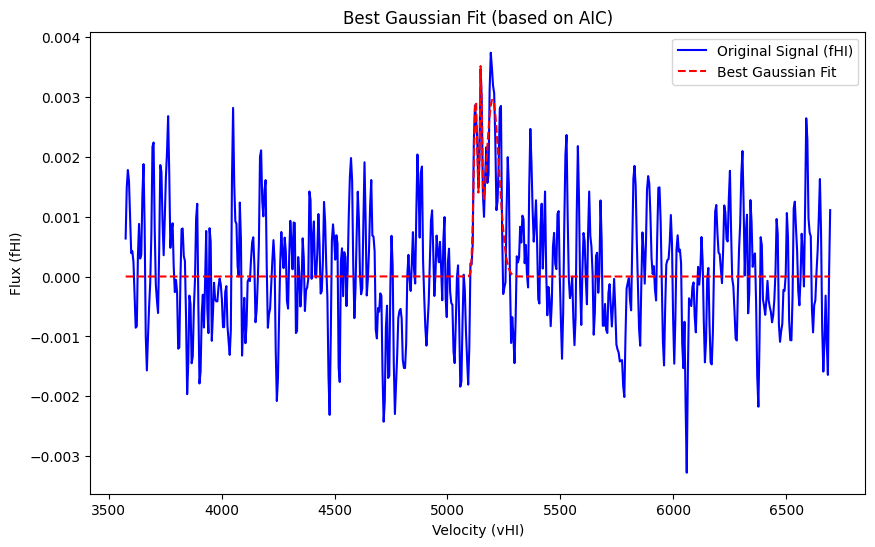

In [15]:
# Load data
file = 'mangaHI-7972-3701.csv'
timeSeries = pd.read_csv(file, names=['vHI', 'fHI', 'fBHI'])

time = timeSeries[22:-1].copy()
time[['vHI', 'fHI', 'fBHI']] = time['vHI'].str.split(expand=True)
time = time.reset_index(drop=True).astype(float)

x = time['vHI'].values
y = time['fHI'].values       # Used for Gaussian fitting (original fHI)
y_original = time['fBHI'].values  # Original signal from fBHI (for plotting)

# Clip signal by omitting the first and last 17% of the points
n_points = len(x)
clip_fraction = 0.17
start_index = int(n_points * clip_fraction)
end_index = int(n_points * (1 - clip_fraction)) - 1

x_trimmed = x[start_index:end_index+1]
y_trimmed = y[start_index:end_index+1]
y_original_trimmed = y_original[start_index:end_index+1]

# Function to fit Gaussian models
def fit_gaussians(num_gaussians):
    fitter = fitting.LevMarLSQFitter()
    
    # Initialize the first Gaussian
    g_init = models.Gaussian1D(amplitude=max(y_trimmed), mean=np.mean(x_trimmed), stddev=10)
    
    # Add additional Gaussians if necessary
    for i in range(1, num_gaussians):
        g_init += models.Gaussian1D(amplitude=max(y_trimmed) / (i + 1), mean=np.mean(x_trimmed) + i * 15, stddev=10)
    
    g_fit = fitter(g_init, x_trimmed, y_trimmed)
    return g_fit

# Fit 1, 2, and 3 gaussian fits
fits = {n: fit_gaussians(n) for n in [1, 2, 3]}

# Compute fit metrics
def compute_metrics(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    snr_points = 20 * np.log10(np.abs(y_trimmed / residuals))

    # Define the spectral line region
    SNR_g_init = models.Gaussian1D(amplitude=max(snr_points), mean=np.mean(x_trimmed), stddev=10)
    SNR_g_fit = fitting.LevMarLSQFitter()(SNR_g_init, x_trimmed, snr_points)
    line_indices = np.where(SNR_g_fit(x_trimmed) > 5)[0]

    if len(line_indices) > 0:
        before_line = np.arange(0, line_indices[0])
        spectral_line = line_indices

        mse_region1 = mean_squared_error(y_trimmed[before_line], g_fit(x_trimmed)[before_line]) if len(before_line) > 0 else np.nan
        mse_region2 = mean_squared_error(y_trimmed[spectral_line], g_fit(x_trimmed)[spectral_line]) if len(spectral_line) > 0 else np.nan

        rmse_region1 = np.sqrt(mse_region1) if not np.isnan(mse_region1) else np.nan
        rmse_region2 = np.sqrt(mse_region2) if not np.isnan(mse_region2) else np.nan

        pct_diff_mse = (abs(mse_region2 - mse_region1) / mse_region1) * 100 if mse_region1 and mse_region1 != 0 else np.nan
        pct_diff_rmse = (abs(rmse_region2 - rmse_region1) / rmse_region1) * 100 if rmse_region1 and rmse_region1 != 0 else np.nan

        mean_line = np.mean(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        std_line = np.std(residuals[spectral_line]) if len(spectral_line) > 0 else np.nan
        mean_non_line = np.mean(residuals[before_line]) if len(before_line) > 0 else np.nan
        std_non_line = np.std(residuals[before_line]) if len(before_line) > 0 else np.nan

        mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100 if mean_non_line != 0 else np.nan
        std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100 if std_non_line > 0 else np.nan

        return {
            "g_fit": g_fit,
            "residuals": residuals,
            "mse": pct_diff_mse,
            "rmse": pct_diff_rmse,
            "mean_diff": mean_diff_percentage,
            "std_diff": std_diff_percentage
        }
    return None

# Compute AIC
def compute_aic(g_fit):
    residuals = y_trimmed - g_fit(x_trimmed)
    ssr = np.sum(residuals**2)  # Sum of squared residuals
    n_params = len(g_fit.parameters)  # Number of parameters in the model
    n_samples = len(y_trimmed)  # Number of data points

    return akaike_info_criterion_lsq(ssr, n_params, n_samples)

# Compute metrics and AIC values for all fits
metrics = {n: compute_metrics(fits[n]) for n in fits if compute_metrics(fits[n]) is not None}
aic_values = {n: compute_aic(fits[n]) for n in fits if fits[n] is not None}

if metrics and aic_values:
    # Select the best fit using the lowest AIC value
    best_fit_n = min(aic_values.items(), key=lambda x: x[1])[0]
    best_fit = fits[best_fit_n]

    # Print comparison results
    print("\n--- Gaussian Fit Comparisons ---")
    for n, result in metrics.items():
        print(f"\nGaussian {n}:")
        print(f"  % Diff in MSE (R1 vs R2): {result['mse']:.2f}%")
        print(f"  % Diff in RMSE (R1 vs R2): {result['rmse']:.2f}%")
        print(f"  % Diff in Mean (Residuals): {result['mean_diff']:.2f}%")
        print(f"  % Diff in Std Dev (Residuals): {result['std_diff']:.2f}%")
        print(f"  AIC Score: {aic_values[n]:.2f}")

    print(f"\nBest fit: {best_fit_n} Gaussian(s) (Lowest AIC = {aic_values[best_fit_n]:.2f})")

    # Plot the best fit
    plt.figure(figsize=(10, 6))
    plt.plot(x_trimmed, y_trimmed, 'b-', label='Original Signal (fHI)')
    plt.plot(x_trimmed, best_fit(x_trimmed), 'r--', label='Best Gaussian Fit')
    plt.xlabel("Velocity (vHI)")
    plt.ylabel("Flux (fHI)")
    plt.legend()
    plt.title("Best Gaussian Fit (based on AIC)")
    plt.show()
else:
    print("No spectral line regions found suitable for fitting.")

### Calculate metrics for detected spectral line (best fit)

--- HI Spectral Line Parameters (on signal) ---
Peak Intensity (I_peak): 0.820 mJy
FWZI (Full Width at Zero Intensity): -1532.400 km/s
W20 (Width at 20% of Peak): -1433.700 km/s
W50 (Width at 50% of Peak): -1116.900 km/s
Systemic Velocity (V_sys): 518.350 km/s
Integrated Flux (Sint): 157.968 Jy km/s


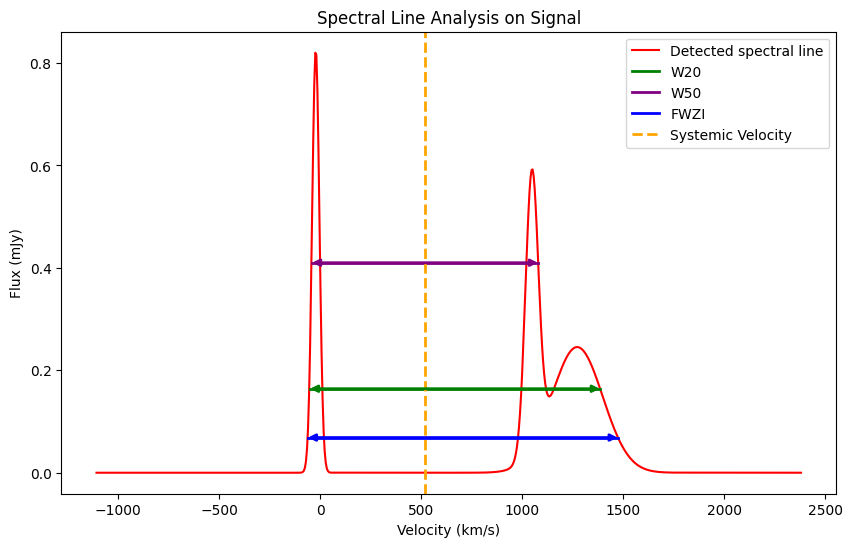

In [31]:
signal = signal_fit

# Peak Intensity (I_peak)
I_peak = np.max(signal)

# Full Width at Zero Intensity (FWZI)
residuals = y_trimmed - signal
sigma_noise = np.std(residuals)
detection_threshold = 2 * sigma_noise

fwzi_mask = np.where(signal >= detection_threshold)[0]
FWZI = x_trimmed[fwzi_mask[-1]] - x_trimmed[fwzi_mask[0]]
fwzi_range = [x_trimmed[fwzi_mask[0]], x_trimmed[fwzi_mask[-1]]]

# W20 (Width at 20% of Peak)
v20_indices = np.where(signal >= 0.2 * I_peak)[0]
W20 = x_trimmed[v20_indices[-1]] - x_trimmed[v20_indices[0]]
w20_range = [x_trimmed[v20_indices[0]], x_trimmed[v20_indices[-1]]]

# W50 (Width at 50% of Peak)
v50_indices = np.where(signal >= 0.5 * I_peak)[0]
W50 = x_trimmed[v50_indices[-1]] - x_trimmed[v50_indices[0]]
w50_range = [x_trimmed[v50_indices[0]], x_trimmed[v50_indices[-1]]]

# Systemic Velocity (V_sys)
V_sys = (x_trimmed[v50_indices[0]] + x_trimmed[v50_indices[-1]]) / 2

# Integrated Flux (Sint)
velocity_channel_width = np.abs(np.mean(np.diff(x_trimmed)))
Sint = np.sum(signal) * velocity_channel_width # Approximate integral

# Print results
print("--- HI Spectral Line Parameters (on signal) ---")
print(f"Peak Intensity (I_peak): {I_peak:.3f} mJy")
print(f"FWZI (Full Width at Zero Intensity): {FWZI:.3f} km/s")
print(f"W20 (Width at 20% of Peak): {W20:.3f} km/s")
print(f"W50 (Width at 50% of Peak): {W50:.3f} km/s")
print(f"Systemic Velocity (V_sys): {V_sys:.3f} km/s")
print(f"Integrated Flux (Sint): {Sint:.3f} Jy km/s")

# Plot signal
plt.figure(figsize=(10, 6))
plt.plot(x_trimmed, signal, 'r-', label='Detected spectral line')

# Horizontal lines
plt.plot(w20_range, [0.2 * I_peak] * 2, 'g-', lw=2, label="W20")
plt.plot(w50_range, [0.5 * I_peak] * 2, 'purple', lw=2, label="W50")
plt.plot(fwzi_range, [detection_threshold] * 2, 'blue', lw=2, label="FWZI")

plt.annotate("", xy=(w20_range[1], 0.2 * I_peak), xytext=(w20_range[0], 0.2 * I_peak),
             arrowprops=dict(arrowstyle="<|-|>", color="g", lw=2, shrinkA=0,shrinkB=0))
plt.annotate("", xy=(w50_range[1], 0.5 * I_peak), xytext=(w50_range[0], 0.5 * I_peak),
             arrowprops=dict(arrowstyle="<|-|>", color="purple", lw=2, shrinkA=0,shrinkB=0))
plt.annotate("", xy=(fwzi_range[1], detection_threshold), xytext=(fwzi_range[0], detection_threshold),
             arrowprops=dict(arrowstyle="<|-|>", color="blue", lw=2, shrinkA=0,shrinkB=0))

# Systemic velocity line
plt.axvline(V_sys, color='orange', linestyle='--', label="Systemic Velocity", lw=2)

plt.xlabel("Velocity (km/s)")
plt.ylabel("Flux (mJy)")
plt.legend()
plt.title("Spectral Line Analysis on Signal")
plt.show()

## Database access

### Connect to database and fetch a single signal

Selected src_file: mangaHI-8716-9101.csv
Fetched 1024 data points.


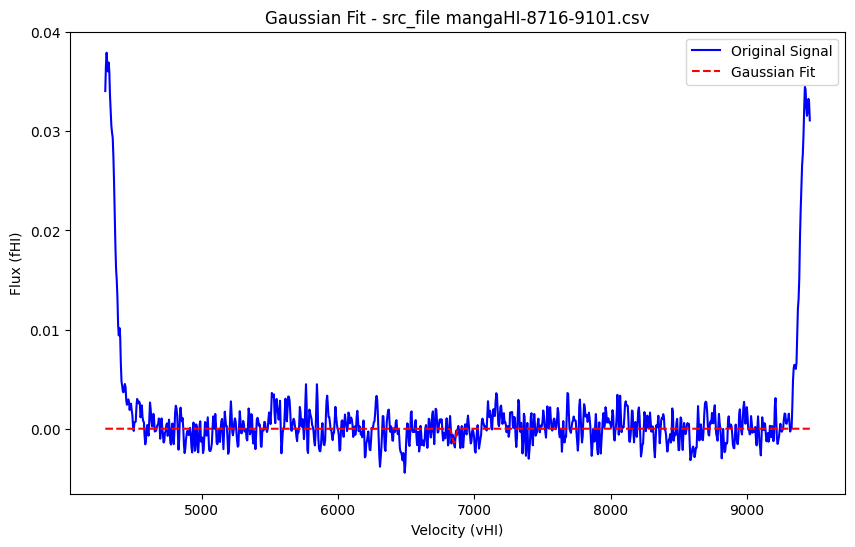

In [2]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all vHI and fHI values for that src_file
    query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
    cursor.execute(query)
    data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

    if data.empty:
        print("No data found for this src_file.")
    else:
        print(f"Fetched {len(data)} data points.")

    # Remove NaNs
    data = data.dropna()

    # Extract velocity and flux
    x = data["vHI"].values
    y = data["fHI"].values

    if len(x) < 3:
        print("Insufficient points for Gaussian fitting.")
    else:
        # Fit a Gaussian
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # Plot original signal and Gaussian fit
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')
        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()
        plt.title(f"Gaussian Fit - src_file {src_file}")
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()

### Fetch 20 random signals from the database and perform gaussian fitting and error estimation

Selected src_file: mangaHI-8263-9101.csv
Selected 20 random signals.
Data from signal mangaHI-8138-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8138-3704.csv:
  Spectral Line Region -> Mean: 0.000055, Std Dev: 0.001077
  Non-Spectral Line Region -> Mean: -0.001459, Std Dev: 0.004572
  Percentage Difference in Mean: 103.78%
  Percentage Difference in Std Dev: -76.45%
--------------------------------------------------


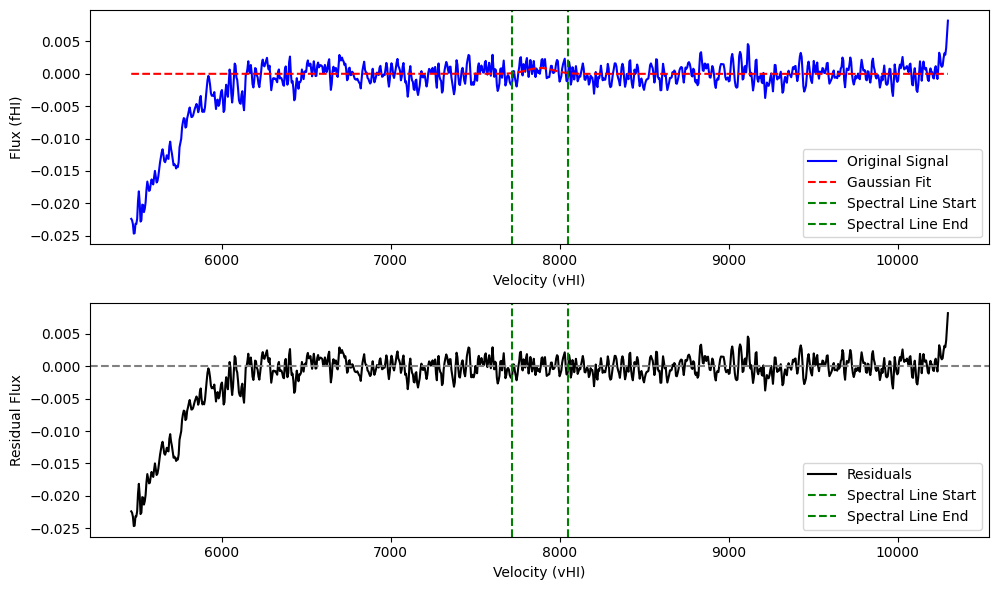

Data from signal mangaHI-9491-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9491-3704.csv:
  Spectral Line Region -> Mean: -0.000142, Std Dev: 0.000851
  Non-Spectral Line Region -> Mean: 0.002064, Std Dev: 0.002930
  Percentage Difference in Mean: -106.86%
  Percentage Difference in Std Dev: -70.97%
--------------------------------------------------


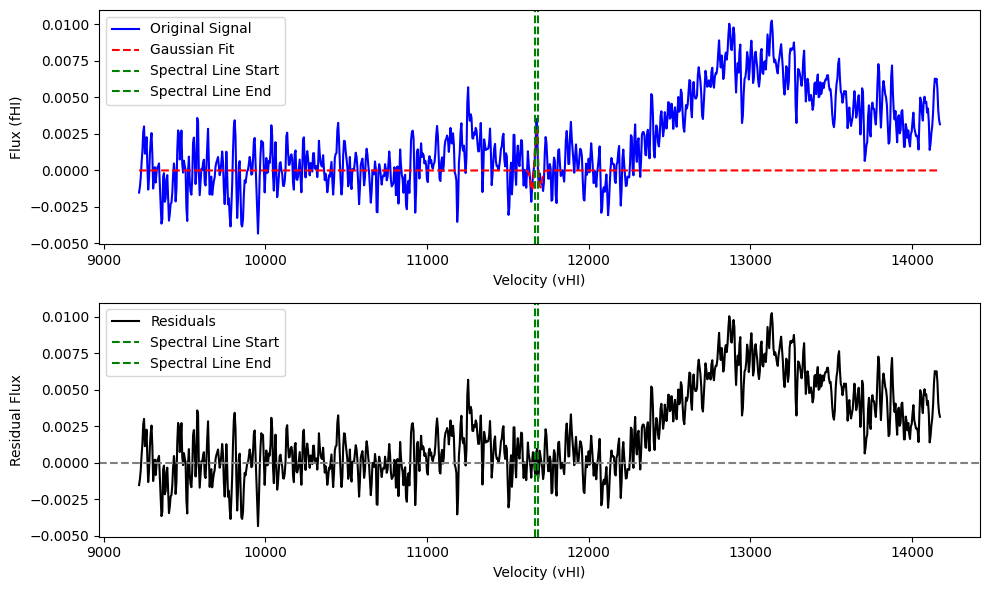

Data from signal mangaHI-9893-3701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9893-3701.csv:
  Spectral Line Region -> Mean: -0.000109, Std Dev: 0.001619
  Non-Spectral Line Region -> Mean: -0.000315, Std Dev: 0.001852
  Percentage Difference in Mean: 65.39%
  Percentage Difference in Std Dev: -12.60%
--------------------------------------------------


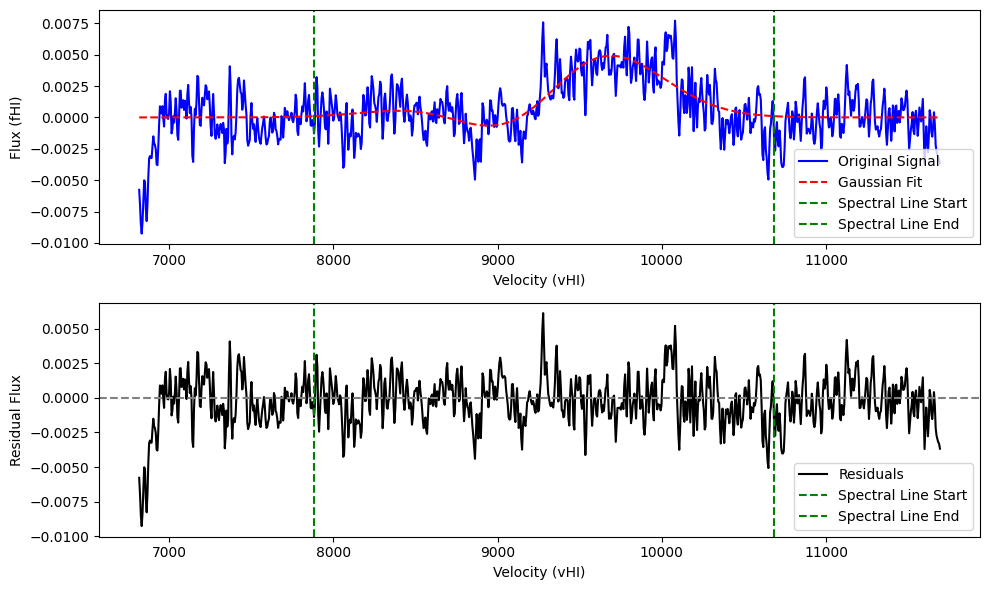

Data from signal mangaHI-9193-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9193-6102.csv:
  Spectral Line Region -> Mean: -0.000043, Std Dev: 0.001636
  Non-Spectral Line Region -> Mean: 0.000078, Std Dev: 0.001204
  Percentage Difference in Mean: -155.05%
  Percentage Difference in Std Dev: 35.95%
--------------------------------------------------


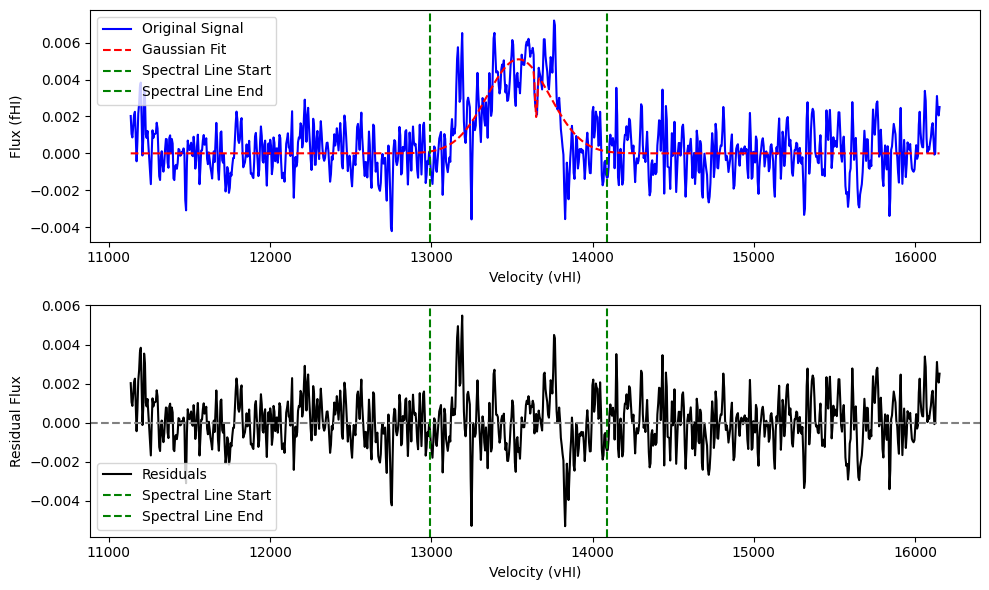

Data from signal mangaHI-8613-3704.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8613-3704.csv:
  Spectral Line Region -> Mean: -0.000096, Std Dev: 0.000735
  Non-Spectral Line Region -> Mean: 0.001157, Std Dev: 0.004235
  Percentage Difference in Mean: -108.29%
  Percentage Difference in Std Dev: -82.64%
--------------------------------------------------


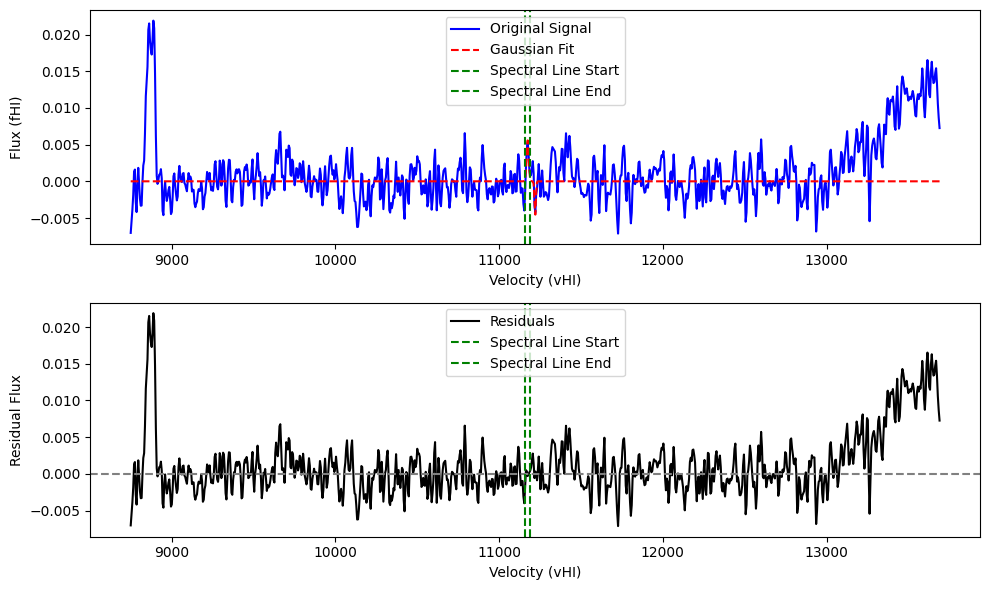

Data from signal mangaHI-9031-3701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9031-3701.csv:
  Spectral Line Region -> Mean: 0.000035, Std Dev: 0.001774
  Non-Spectral Line Region -> Mean: 0.074205, Std Dev: 0.387801
  Percentage Difference in Mean: -99.95%
  Percentage Difference in Std Dev: -99.54%
--------------------------------------------------


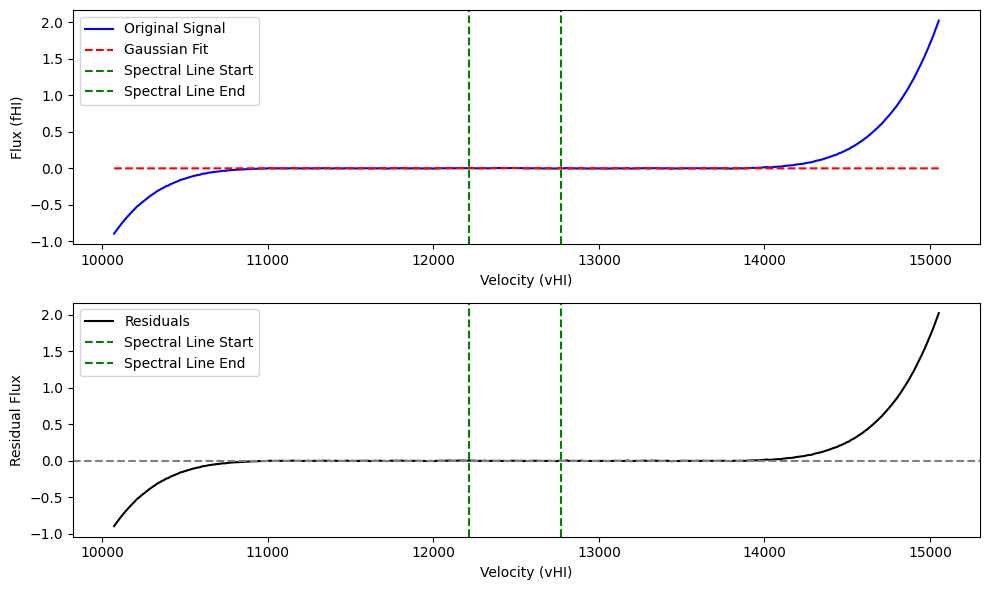

Data from signal mangaHI-9869-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9869-12705.csv:
  Spectral Line Region -> Mean: -0.000005, Std Dev: 0.001007
  Non-Spectral Line Region -> Mean: -0.000073, Std Dev: 0.001110
  Percentage Difference in Mean: 93.16%
  Percentage Difference in Std Dev: -9.26%
--------------------------------------------------


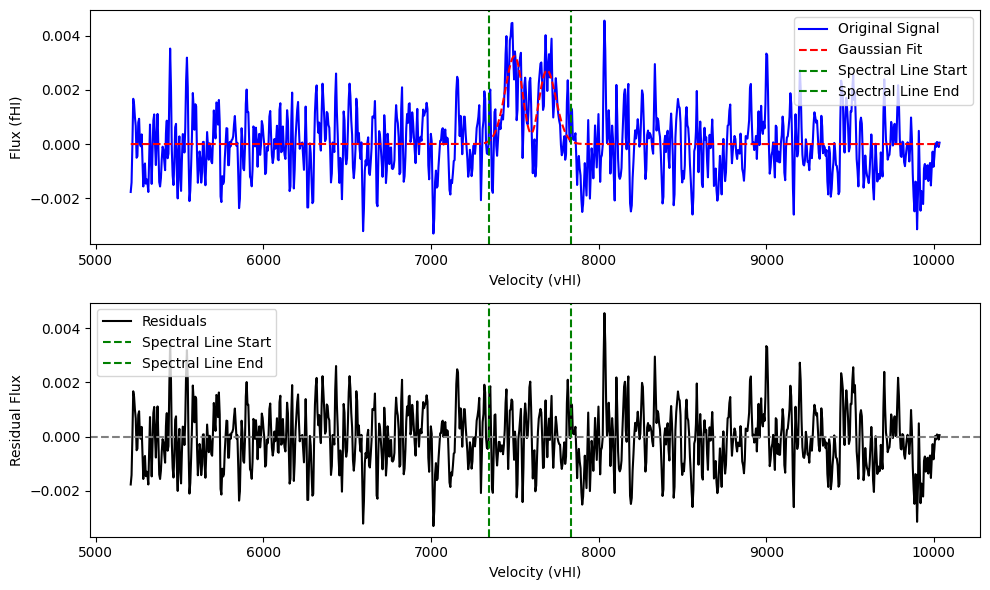

Data from signal mangaHI-8623-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8623-6102.csv:
  Spectral Line Region -> Mean: -0.000067, Std Dev: 0.001542
  Non-Spectral Line Region -> Mean: -0.177267, Std Dev: 0.544518
  Percentage Difference in Mean: 99.96%
  Percentage Difference in Std Dev: -99.72%
--------------------------------------------------


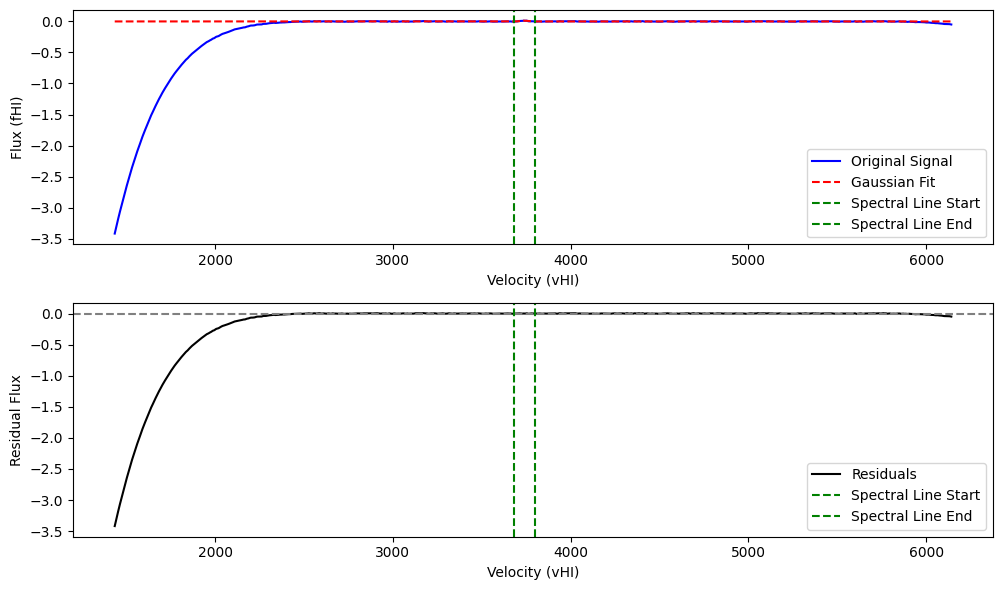

Data from signal mangaHI-9000-1902.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9000-1902.csv:
  Spectral Line Region -> Mean: -0.000002, Std Dev: 0.000684
  Non-Spectral Line Region -> Mean: -0.000247, Std Dev: 0.001777
  Percentage Difference in Mean: 99.01%
  Percentage Difference in Std Dev: -61.54%
--------------------------------------------------


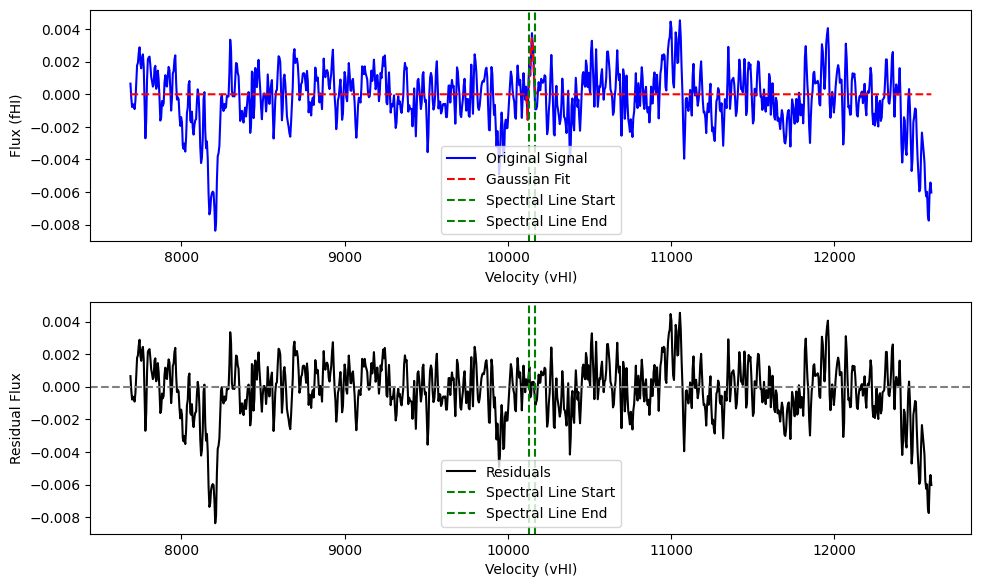

Data from signal mangaHI-8239-6102.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8239-6102.csv:
  Spectral Line Region -> Mean: 0.000205, Std Dev: 0.000517
  Non-Spectral Line Region -> Mean: 0.264310, Std Dev: 0.631633
  Percentage Difference in Mean: -99.92%
  Percentage Difference in Std Dev: -99.92%
--------------------------------------------------


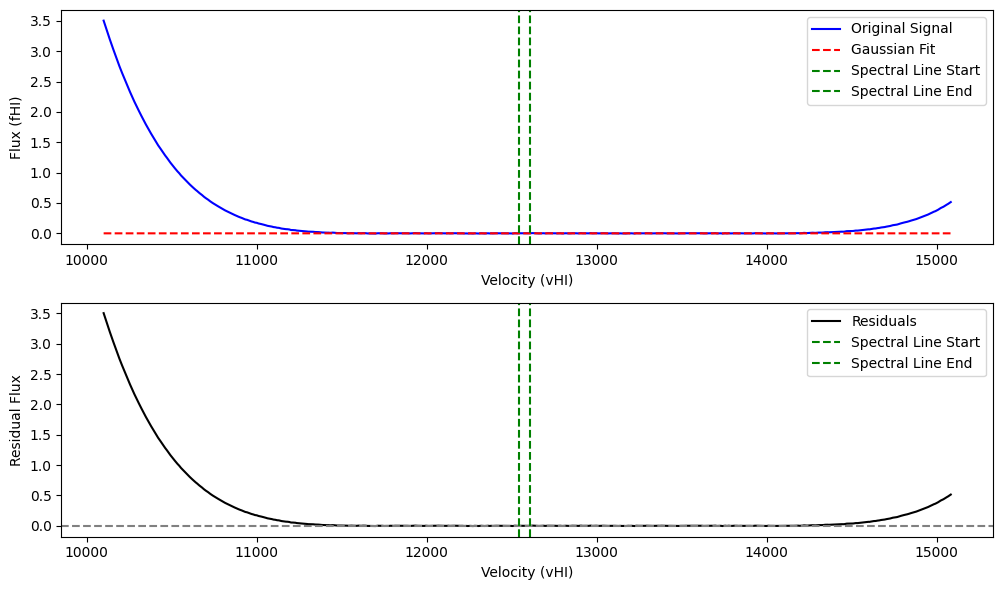

Data from signal mangaHI-7960-6104.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-7960-6104.csv:
  Spectral Line Region -> Mean: -0.000087, Std Dev: 0.001073
  Non-Spectral Line Region -> Mean: 0.003589, Std Dev: 0.012258
  Percentage Difference in Mean: -102.43%
  Percentage Difference in Std Dev: -91.25%
--------------------------------------------------


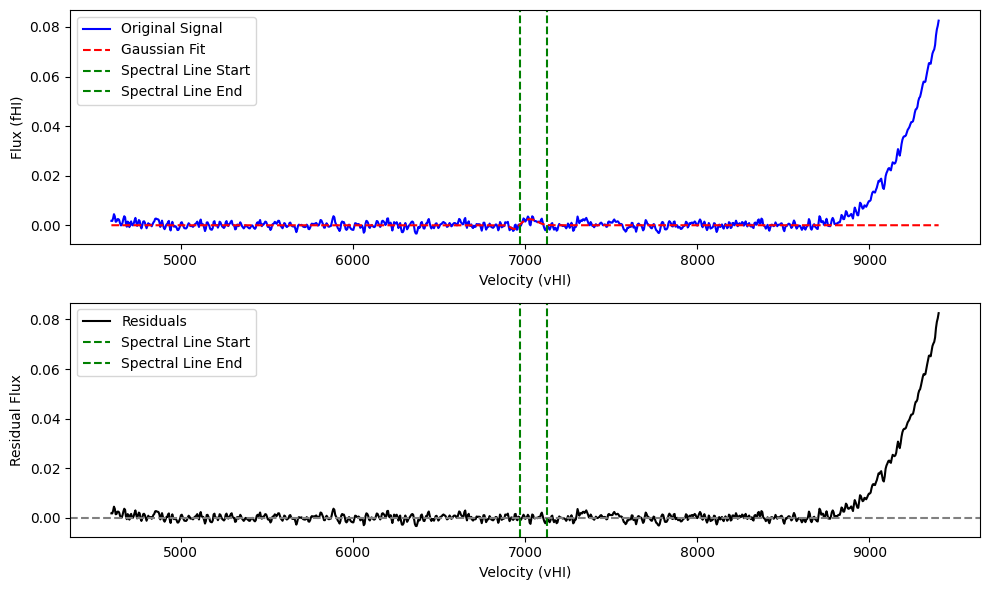

Data from signal mangaHI-9190-6104.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9190-6104.csv:
  Spectral Line Region -> Mean: -0.000078, Std Dev: 0.000769
  Non-Spectral Line Region -> Mean: 0.000158, Std Dev: 0.001978
  Percentage Difference in Mean: -149.23%
  Percentage Difference in Std Dev: -61.12%
--------------------------------------------------


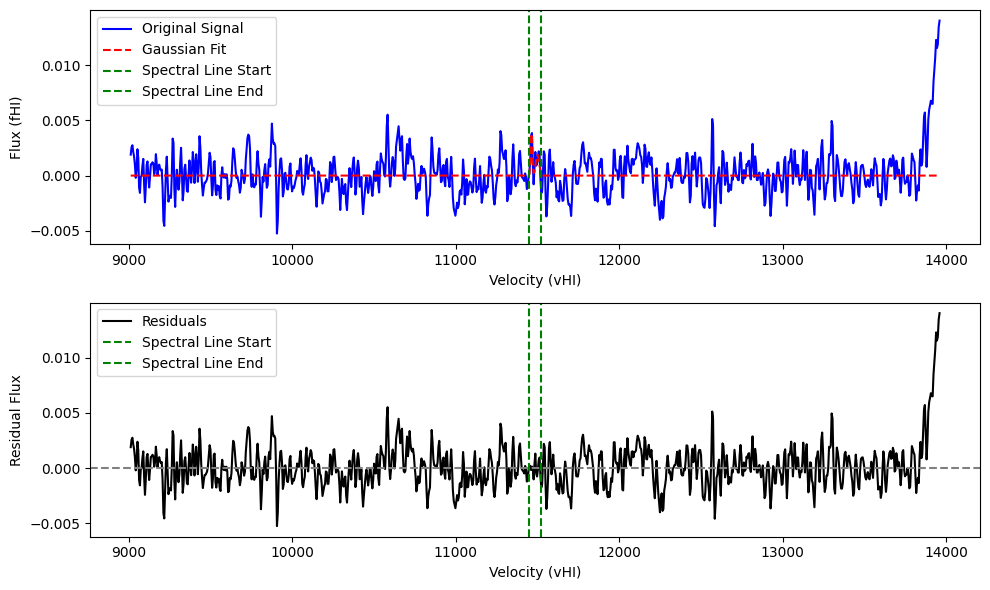

Data from signal mangaHI-9485-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9485-12701.csv:
  Spectral Line Region -> Mean: -0.000188, Std Dev: 0.000951
  Non-Spectral Line Region -> Mean: -0.000048, Std Dev: 0.002614
  Percentage Difference in Mean: -291.07%
  Percentage Difference in Std Dev: -63.63%
--------------------------------------------------


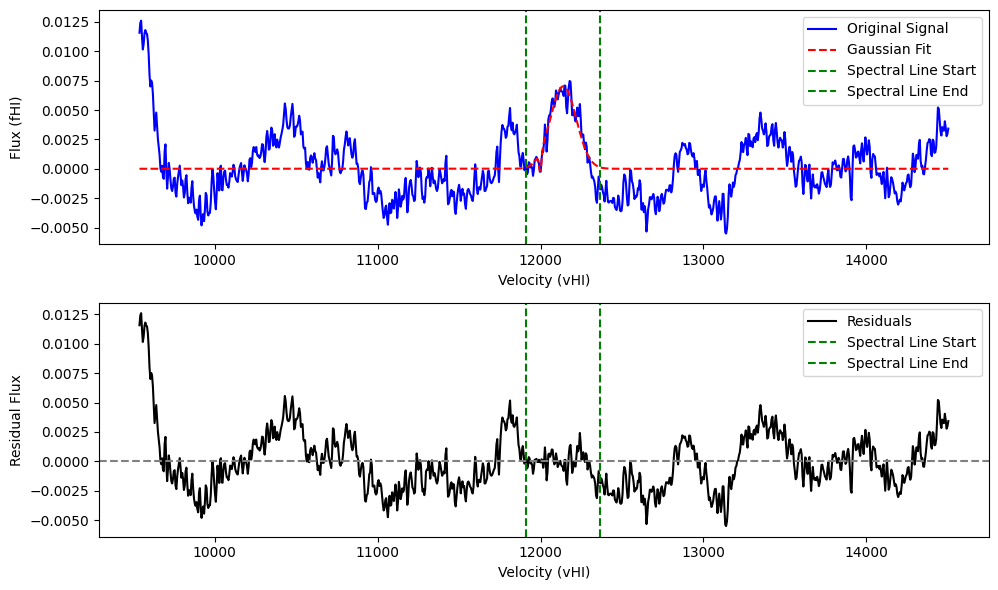

Data from signal mangaHI-9037-9101.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9037-9101.csv:
  Spectral Line Region -> Mean: 0.000011, Std Dev: 0.001621
  Non-Spectral Line Region -> Mean: -0.000825, Std Dev: 0.003122
  Percentage Difference in Mean: 101.34%
  Percentage Difference in Std Dev: -48.07%
--------------------------------------------------


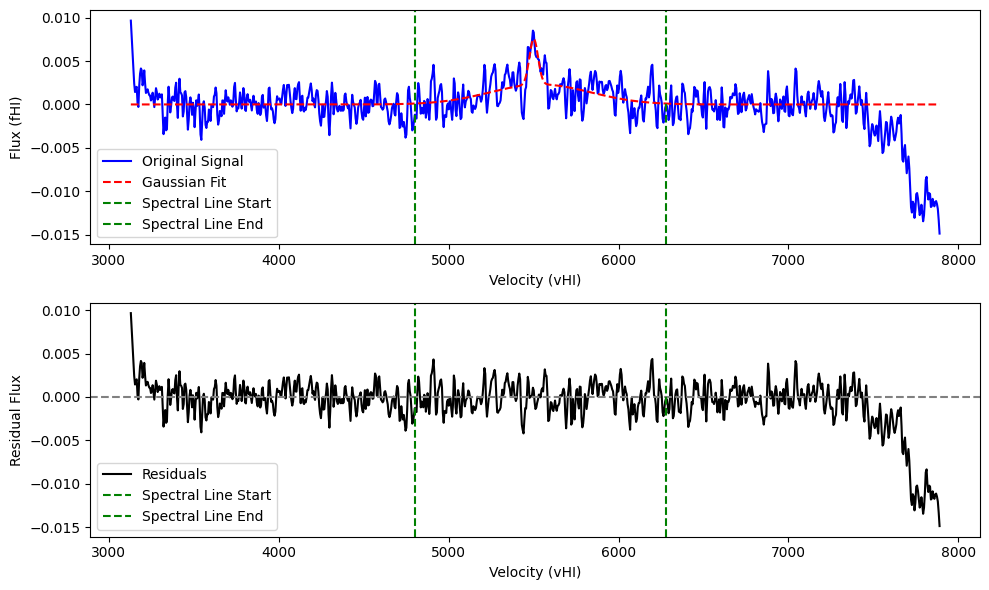

Data from signal mangaHI-8317-3702.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8317-3702.csv:
  Spectral Line Region -> Mean: -0.000107, Std Dev: 0.001346
  Non-Spectral Line Region -> Mean: 0.000093, Std Dev: 0.001639
  Percentage Difference in Mean: -214.14%
  Percentage Difference in Std Dev: -17.87%
--------------------------------------------------


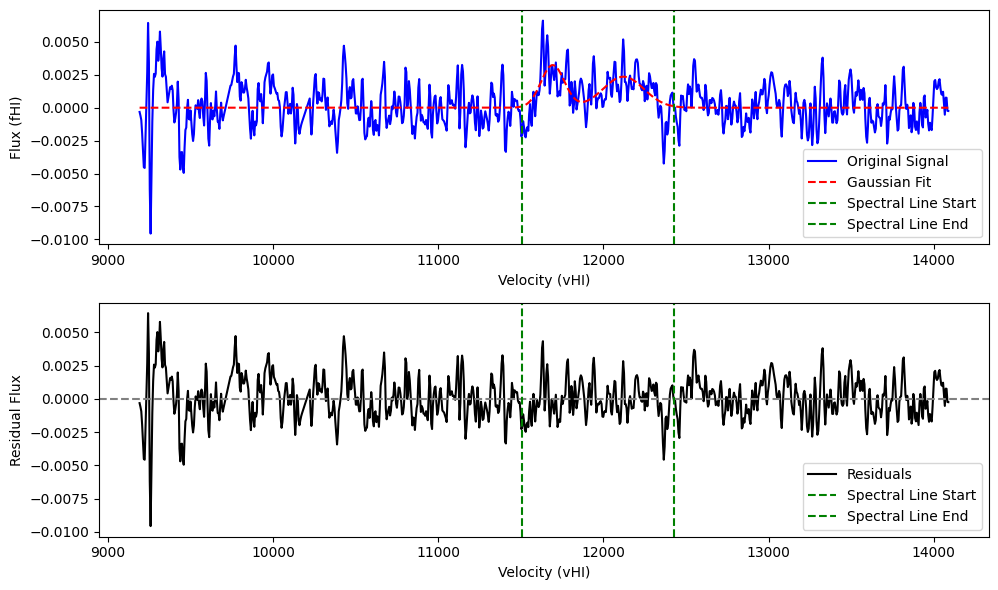

Data from signal mangaHI-8484-6104.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8484-6104.csv:
  Spectral Line Region -> Mean: 0.002550, Std Dev: 0.003482
  Non-Spectral Line Region -> Mean: -0.001544, Std Dev: 0.013220
  Percentage Difference in Mean: 265.20%
  Percentage Difference in Std Dev: -73.66%
--------------------------------------------------


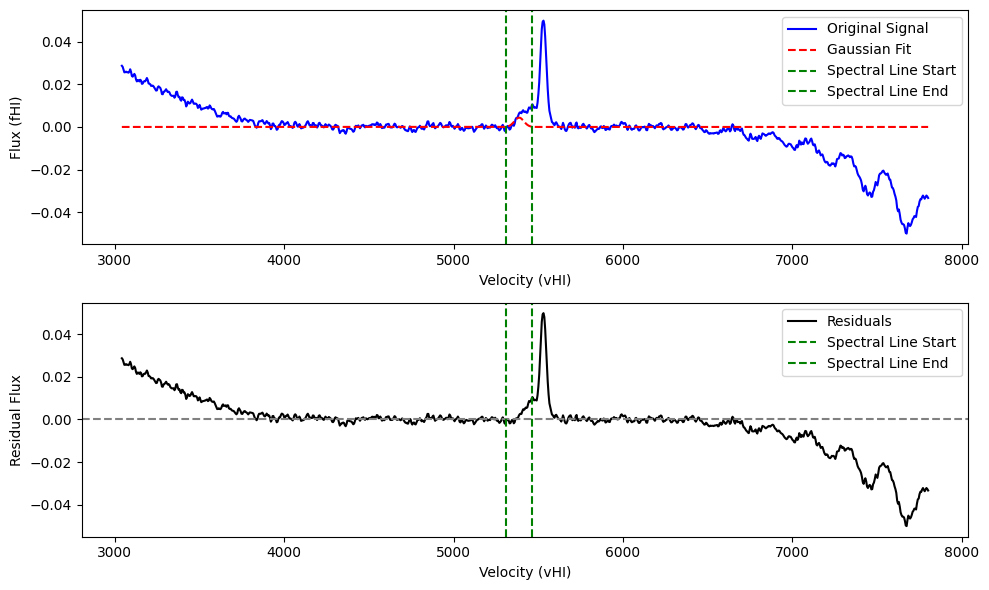

Data from signal mangaHI-8440-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8440-12705.csv:
  Spectral Line Region -> Mean: -0.000118, Std Dev: 0.002295
  Non-Spectral Line Region -> Mean: 0.000049, Std Dev: 0.001444
  Percentage Difference in Mean: -338.26%
  Percentage Difference in Std Dev: 58.95%
--------------------------------------------------


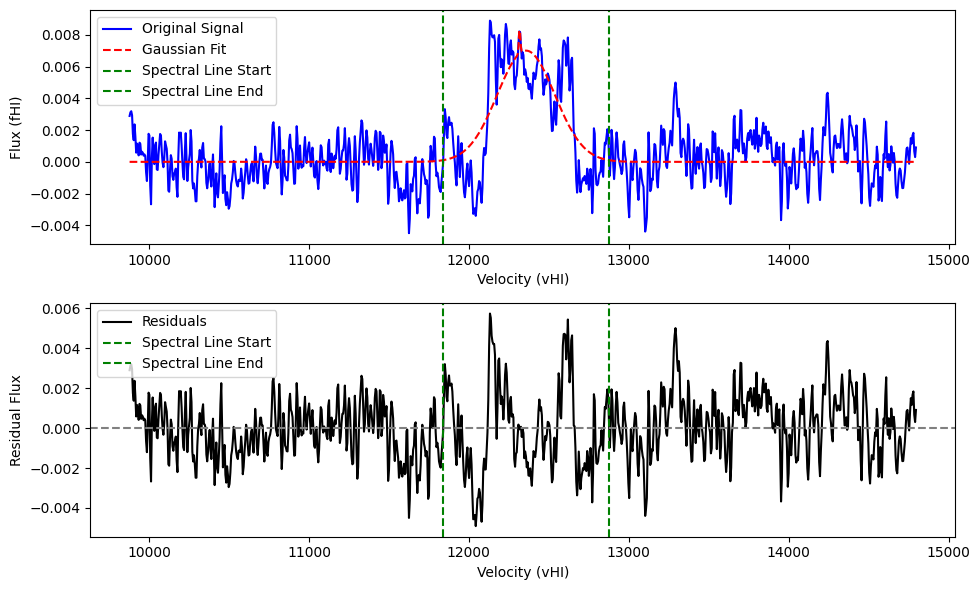

Data from signal mangaHI-9036-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-9036-12701.csv:
  Spectral Line Region -> Mean: -0.000136, Std Dev: 0.001343
  Non-Spectral Line Region -> Mean: 0.000004, Std Dev: 0.001516
  Percentage Difference in Mean: -3576.88%
  Percentage Difference in Std Dev: -11.40%
--------------------------------------------------


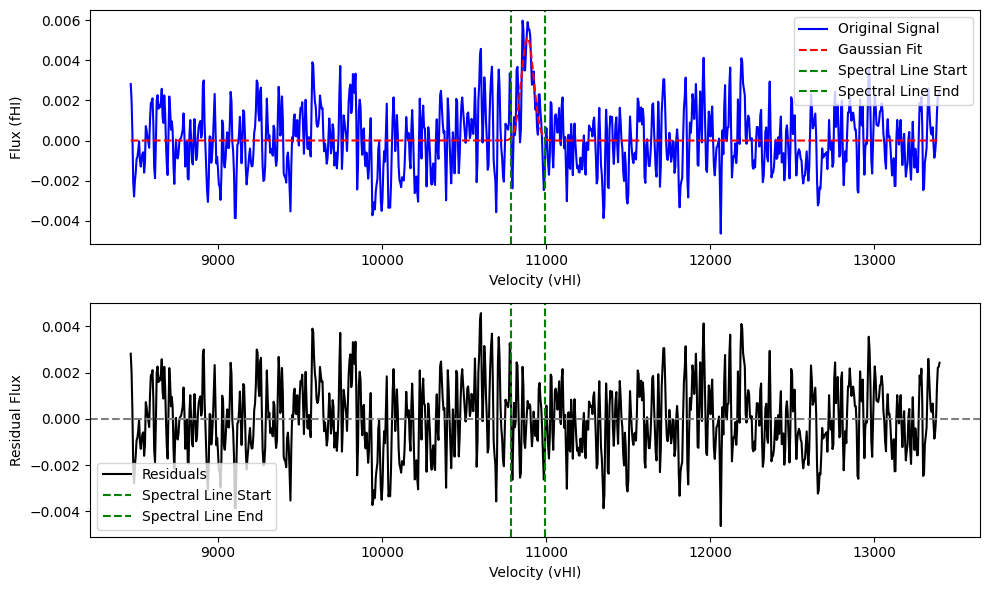

Data from signal mangaHI-8446-12705.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-8446-12705.csv:
  Spectral Line Region -> Mean: -0.000168, Std Dev: 0.001884
  Non-Spectral Line Region -> Mean: 0.027795, Std Dev: 0.072920
  Percentage Difference in Mean: -100.61%
  Percentage Difference in Std Dev: -97.42%
--------------------------------------------------


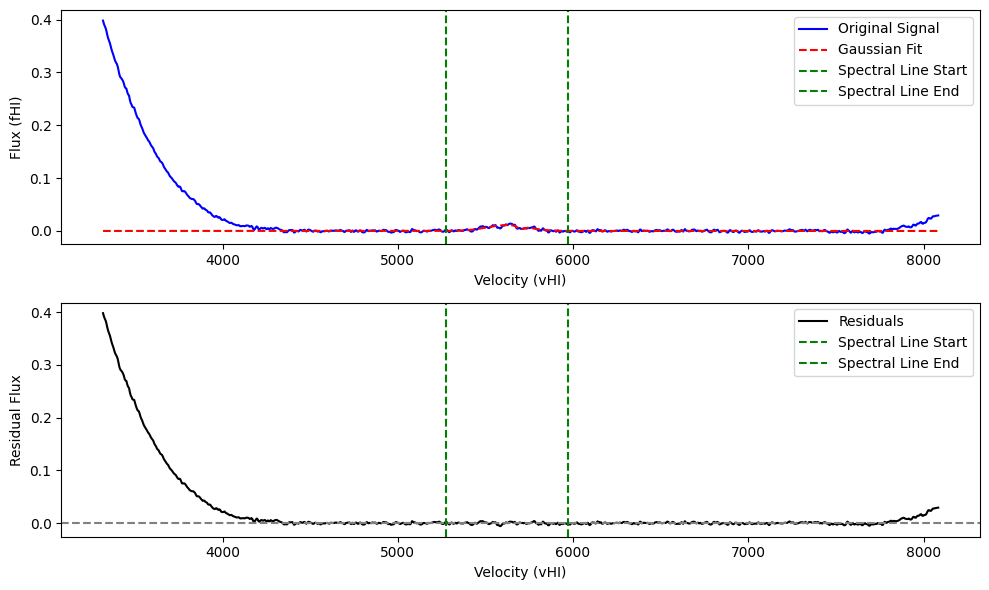

Data from signal mangaHI-11021-12701.csv can't be described by a single Gaussian fit.
Results for signal mangaHI-11021-12701.csv:
  Spectral Line Region -> Mean: -0.000328, Std Dev: 0.001779
  Non-Spectral Line Region -> Mean: -0.000017, Std Dev: 0.001221
  Percentage Difference in Mean: -1836.05%
  Percentage Difference in Std Dev: 45.69%
--------------------------------------------------


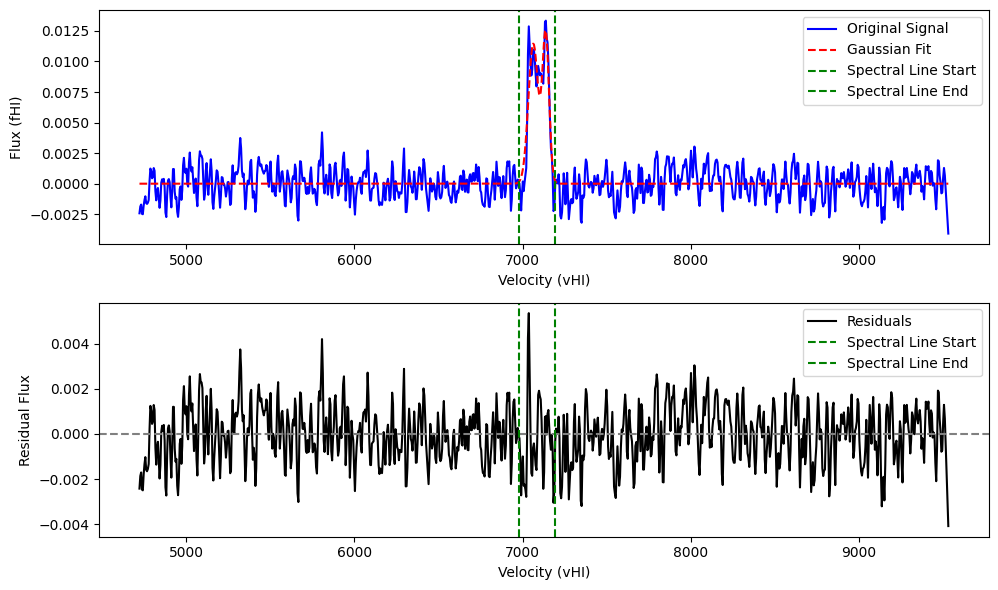

In [3]:
# Database connection details
db_config = {
    "host": "195.201.104.116",
    "user": "eta14802_astrobeam",
    "password": "PGdAR{F[1C#~",
    "database": "eta14802_astrobeam"
}

# Connect to the database
try:
    conn = mysql.connector.connect(**db_config)
    cursor = conn.cursor()

    # Find a src_file that has multiple points
    query = "SELECT src_file, COUNT(*) FROM gbt_data GROUP BY src_file ORDER BY COUNT(*) DESC LIMIT 1;"
    cursor.execute(query)
    src_file = cursor.fetchone()[0]
    print(f"Selected src_file: {src_file}")

    # Fetch all src_file names for sampling 20 random signals
    query = "SELECT DISTINCT src_file FROM gbt_data;"
    cursor.execute(query)
    src_files = [row[0] for row in cursor.fetchall()]
    
    # Randomly select 20 signals
    random_signals = random.sample(src_files, 20)
    print(f"Selected {len(random_signals)} random signals.")

    for src_file in random_signals:
        # Fetch all vHI and fHI values for the signal
        query = f"SELECT vHI, fHI FROM gbt_data WHERE src_file = '{src_file}' ORDER BY vHI;"
        cursor.execute(query)
        data = pd.DataFrame(cursor.fetchall(), columns=["vHI", "fHI"])

        # Remove NaNs
        data = data.dropna()

        # Extract velocity and flux
        x = data["vHI"].values
        y = data["fHI"].values

        # Perform normality test to check if a single Gaussian is sufficient
        stat, p_value = normaltest(y)

        # Fit a single Gaussian first
        fitter = fitting.LevMarLSQFitter()
        g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10)
        g_fit = fitter(g_init, x, y)

        # If the normality test fails (low p-value), attempt a double Gaussian fit
        if p_value < 0.05:
            print(f"Data from signal {src_file} can't be described by a single Gaussian fit.")
            g_init = models.Gaussian1D(amplitude=np.max(y), mean=np.median(x), stddev=10) + \
                     models.Gaussian1D(amplitude=np.max(y)/2, mean=np.median(x) + 10, stddev=10)
            g_fit = fitter(g_init, x, y)

        # Subtract the Gaussian fit from the original signal
        residuals = y - g_fit(x)

        # Identify spectral line region based on nonzero values of the Gaussian fit
        line_indices = np.where(g_fit(x) > 0.0001)[0]  # Indices where the fit is (practically) nonzero
        non_line_indices = np.setdiff1d(np.arange(len(x)), line_indices)  # Everything else

        # Compute noise statistics
        mean_line = np.mean(residuals[line_indices]) if len(line_indices) > 0 else np.nan
        std_line = np.std(residuals[line_indices]) if len(line_indices) > 0 else np.nan

        mean_non_line = np.mean(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan
        std_non_line = np.std(residuals[non_line_indices]) if len(non_line_indices) > 0 else np.nan

        # Compute percentage differences
        if std_non_line > 0:
            std_diff_percentage = ((std_line - std_non_line) / std_non_line) * 100
        else:
            std_diff_percentage = np.nan

        if mean_non_line != 0:
            mean_diff_percentage = ((mean_line - mean_non_line) / abs(mean_non_line)) * 100
        else:
            mean_diff_percentage = np.nan

        # Print results
        print(f"Results for signal {src_file}:")
        print(f"  Spectral Line Region -> Mean: {mean_line:.6f}, Std Dev: {std_line:.6f}")
        print(f"  Non-Spectral Line Region -> Mean: {mean_non_line:.6f}, Std Dev: {std_non_line:.6f}")
        print(f"  Percentage Difference in Mean: {mean_diff_percentage:.2f}%")
        print(f"  Percentage Difference in Std Dev: {std_diff_percentage:.2f}%")
        print("-" * 50)

        # Plot results
        plt.figure(figsize=(10, 6))

        # Plot original signal and Gaussian fit
        plt.subplot(2, 1, 1)
        plt.plot(x, y, 'b-', label='Original Signal')
        plt.plot(x, g_fit(x), 'r--', label='Gaussian Fit')

        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Flux (fHI)")
        plt.legend()

        # Plot residuals
        plt.subplot(2, 1, 2)
        plt.plot(x, residuals, '-k', label='Residuals')
        plt.axhline(0, color='gray', linestyle='--')

        # Mark spectral line region in residuals
        if len(line_indices) > 0:
            plt.axvline(x[line_indices[0]], color='g', linestyle='--', label="Spectral Line Start")
            plt.axvline(x[line_indices[-1]], color='g', linestyle='--', label="Spectral Line End")

        plt.xlabel("Velocity (vHI)")
        plt.ylabel("Residual Flux")
        plt.legend()

        plt.tight_layout()
        plt.show()

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    cursor.close()
    conn.close()


Selected src_file: mangaHI-8716-9101.csv
Fetched 1024 data points.


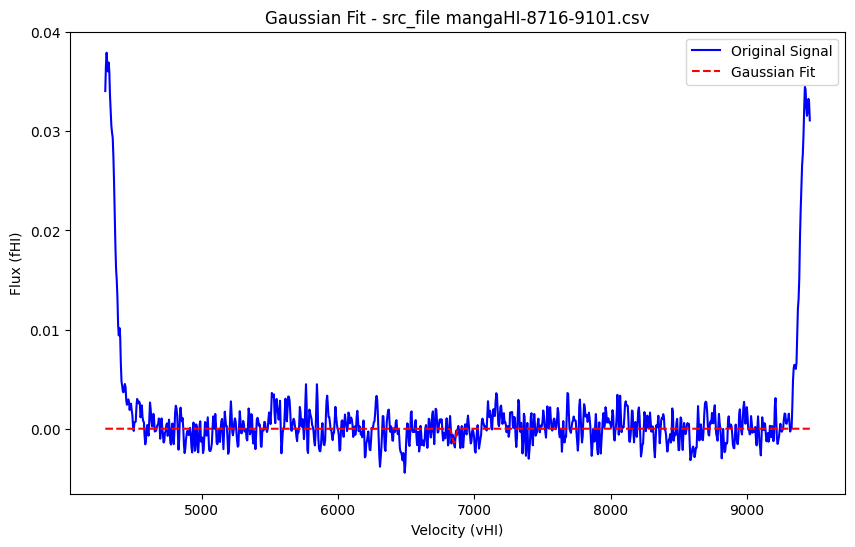